In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(44, 79105)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Footprint' in col ]

['FootprintFraction N year 1 g and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 i and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 r and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 u and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 y and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 z and night < 365 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_11_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_20_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_2_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_46_5 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_5_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_73_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs_priority HealpixSlicer',
 'Sum GalplaneFootprintMetric_clementini_stellarpops_map_Tau_

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
baseline_v2.0_10yrs                26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs                26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs                26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs                26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs                26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs                26.791240  26.452295  26.924920  25.335268   
ddf_half_v3.3_10yrs                26.780815  26.437642  26.917132  25.335917   
ddf_loaded_fl15_v3.3_10yrs         26.786022  26.443637  26.916761  25.344099   
ddf_loaded_fl1_v3.3_10yrs          26.792767  26.469026  26.942059  25.363050   
ddf_loaded_fl2_v3.3_10yrs          26.795351  26.457187  26.931326  25.349788   
ddf_loaded_fl4_v3.3_10yrs          26.795748  26.455168  26.932023  25.342574   
ddf_loaded_fl8_v3.3_10yrs          26.778476  26.448467  26.922085  25.343880   
ddf_loaded_half_fl15_v3.3_10yrs    26.783011  26.442429  26.922675  25.333760   
ddf_loaded_half_fl1_v3.3_10yrs     26.793435  26.464032  26.938387  25.351494   
ddf_loaded_half_fl2_v3.3_10yrs     26.786126  26.461549  26.934301  25.341054   
ddf_loaded_half_fl4_v3.3_10yrs     26.791226  26.454728  26.925296  25.341235   
ddf_loaded_half_fl8_v3.3_10yrs     26.774037  26.451295  26.925285  25.333899   
m2_baseline_v3.3_10yrs             26.786506  26.441868  26.924207  25.332839   
new_twi_bf_v3.3_10yrs              26.787644  26.443635  26.928787  25.342094   
noroll_v3.3_10yrs                  26.815335  26.470599  26.952745  25.371679   
old_throu_baseline_v3.3_10yrs      26.783351  26.443880  26.926541  25.335179   
retro_baseline_v2.0_10yrs          26.835006  26.308518  26.850968  25.707301   
roll_mid1_const_season2v3.3_10yrs  26.797937  26.449654  26.927583  25.353833   
roll_mid1_const_season4v3.3_10yrs  26.795109  26.447895  26.923075  25.351437   
roll_mid1_const_season6v3.3_10yrs  26.787341  26.448179  26.929104  25.341666   
roll_mid2_const_season2v3.3_10yrs  26.799564  26.458947  26.935988  25.358629   
roll_mid2_const_season4v3.3_10yrs  26.800098  26.450187  26.933047  25.343865   
roll_mid2_const_season6v3.3_10yrs  26.800098  26.450187  26.933047  25.343865   
weather_cloudso0v3.3_10yrs         26.791240  26.452295  26.924920  25.335268   
weather_cloudso10v3.3_10yrs        26.795999  26.469606  26.949849  25.342587   
weather_cloudso12v3.3_10yrs        26.798535  26.461049  26.938912  25.331580   
weather_cloudso14v3.3_10yrs        26.794880  26.467619  26.938384  25.330333   
weather_cloudso16v3.3_10yrs        26.803926  26.464125  26.945572  25.336473   
weather_cloudso18v3.3_10yrs        26.808900  26.456666  26.944123  25.335461   
weather_cloudso1v3.3_10yrs         26.803823  26.463671  26.942020  25.355413   
weather_cloudso20v3.3_10yrs        26.792782  26.454521  26.935097  25.326233   
weather_cloudso2v3.3_10yrs         26.810046  26.473008  26.952719  25.353362   
weather_cloudso30v3.3_10yrs        26.769987  26.454323  26.926703  25.309715   
weather_cloudso31v3.3_10yrs        26.777185  26.461465  26.932040  25.320642   
weather_cloudso35v3.3_10yrs        26.775024  26.453103  26.932771  25.313326   
weather_cloudso36v3.3_10yrs        26.786937  26.460090  26.931938  25.324237   
weather_cloudso4v3.3_10yrs         26.823988  26.477366  26.959271  25.362813   
weather_cloudso6v3.3_10yrs         26.832235  26.485654  26.968354  25.374046   
weather_cloudso8v3.3_10yrs         26.795055  26.470325  26.938333  25.329696   

                                           y          z  
baseline_v2.0_10yrs                24.762720  25.510379  
baseline_v2.1_10yrs                24.728145  25.486640  
baseline_v2.2_10yrs                24.782743  25.581317  
baseline_v3.0_10yrs                24.756955  25.524781  
baseline_v3.2_10yrs                24.766647  25.586860  
baseline_v3.3_10yrs                24.801880  25.

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS   N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs                 638.253284   586.826209   974.231557   
baseline_v2.1_10yrs                 548.479625   545.669910   875.981802   
baseline_v2.2_10yrs                 708.239238   685.202422  1067.553931   
baseline_v3.0_10yrs                 955.159293   799.584601  1266.961769   
baseline_v3.2_10yrs                 971.481238   868.593513  1528.851192   
baseline_v3.3_10yrs                1075.737859   908.756078  1771.828689   
ddf_half_v3.3_10yrs                1269.684744  1228.508520  1977.909377   
ddf_loaded_fl15_v3.3_10yrs         1334.123693  1242.949715  2001.327893   
ddf_loaded_fl1_v3.3_10yrs          1004.355390   805.406674  1452.421338   
ddf_loaded_fl2_v3.3_10yrs          1074.103119  1001.202708  1694.334532   
ddf_loaded_fl4_v3.3_10yrs          1189.048276  1124.814687  1851.335955   
ddf_loaded_fl8_v3.3_10yrs          1260.548390  1211.509849  1917.127176   
ddf_loaded_half_fl15_v3.3_10yrs    1383.742233  1346.817492  2055.172818   
ddf_loaded_half_fl1_v3.3_10yrs     1114.514839  1060.236530  1671.547957   
ddf_loaded_half_fl2_v3.3_10yrs     1222.912134  1178.995874  1897.006124   
ddf_loaded_half_fl4_v3.3_10yrs     1272.134428  1257.993838  1954.624844   
ddf_loaded_half_fl8_v3.3_10yrs     1339.088686  1298.132236  2040.979289   
m2_baseline_v3.3_10yrs             1054.970780   913.510906  1770.662687   
new_twi_bf_v3.3_10yrs              1086.483722   919.060577  1822.663749   
noroll_v3.3_10yrs                  1162.511474  1099.771940  1832.048472   
old_throu_baseline_v3.3_10yrs      1056.458453   913.661225  1768.951538   
retro_baseline_v2.0_10yrs           633.216869   678.859654  1098.712998   
roll_mid1_const_season2v3.3_10yrs  1044.575200   964.982837  1739.786660   
roll_mid1_const_season4v3.3_10yrs  1060.600064   925.774477  1741.479119   
roll_mid1_const_season6v3.3_10yrs  1118.434444   940.637759  1726.943722   
roll_mid2_const_season2v3.3_10yrs  1106.479639  1007.285874  1770.049911   
roll_mid2_const_season4v3.3_10yrs  1122.052433  1004.294181  1750.537181   
roll_mid2_const_season6v3.3_10yrs  1122.052433  1004.294181  1750.537181   
weather_cloudso0v3.3_10yrs         1075.737859   908.756078  1771.828689   
weather_cloudso10v3.3_10yrs        1025.326899   843.611595  1566.050543   
weather_cloudso12v3.3_10yrs         980.179119   865.711012  1635.728278   
weather_cloudso14v3.3_10yrs        1009.917913   843.455839  1497.562876   
weather_cloudso16v3.3_10yrs         980.053272   889.382085  1522.084374   
weather_cloudso18v3.3_10yrs        1006.631286   856.607897  1472.996772   
weather_cloudso1v3.3_10yrs         1047.501831   963.620365  1750.926246   
weather_cloudso20v3.3_10yrs        1003.626670   843.958658  1518.293406   
weather_cloudso2v3.3_10yrs         1088.224074   944.032829  1709.079206   
weather_cloudso30v3.3_10yrs        1006.921600   889.422336  1434.921798   
weather_cloudso31v3.3_10yrs         990.156754   822.342203  1484.596296   
weather_cloudso35v3.3_10yrs         977.686590   882.139036  1515.783230   
weather_cloudso36v3.3_10yrs        1007.932489   849.350587  1475.353583   
weather_cloudso4v3.3_10yrs         1060.800175   939.195427  1752.234822   
weather_cloudso6v3.3_10yrs         1066.482262   925.290314  1793.129876   
weather_cloudso8v3.3_10yrs         1042.936783   849.813132  1657.190495   

                                   N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs                  684.401547    611.229060     0.503926   
baseline_v2.1_10yrs                  636.634918    520.071105     0.496150   
baseline_v2.2_10yrs                  674.561648    611.247120     0.493897   
baseline_v3.0_10yrs                  688.808879    726.491723     0.503734   
baseline_v3.2_10yrs                  844.740564    840.405268     0.510969   
baseline_v3.3_10yrs                  945.924749    941.173826     0.539771   
ddf_half_v3.3_10yrs                 1224.312270   1316.863400     0.

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
baseline_v2.0_10yrs                0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs                0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs                0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs                0.257192  0.257425   3.984706  0.213736   
baseline_v3.2_10yrs                0.140020  0.100247   3.084814  0.605912   
baseline_v3.3_10yrs                0.208421  0.110505   3.557980  0.119924   
ddf_half_v3.3_10yrs                0.198256  0.083974   3.525808  0.134937   
ddf_loaded_fl15_v3.3_10yrs         0.187485  0.104817   3.429804  0.132373   
ddf_loaded_fl1_v3.3_10yrs          0.229216  0.135124   3.682660  0.138015   
ddf_loaded_fl2_v3.3_10yrs          0.163659  0.121229   3.770691  0.122208   
ddf_loaded_fl4_v3.3_10yrs          0.178207  0.120903   3.493542  0.117312   
ddf_loaded_fl8_v3.3_10yrs          0.192474  0.121835   3.606425  0.132513   
ddf_loaded_half_fl15_v3.3_10yrs    0.154287  0.119178   3.656968  0.134797   
ddf_loaded_half_fl1_v3.3_10yrs     0.212897  0.096191   3.484637  0.163333   
ddf_loaded_half_fl2_v3.3_10yrs     0.176155  0.125425   3.414697  0.153355   
ddf_loaded_half_fl4_v3.3_10yrs     0.161375  0.145848   3.538024  0.154427   
ddf_loaded_half_fl8_v3.3_10yrs     0.193360  0.152422   3.628759  0.166503   
m2_baseline_v3.3_10yrs             0.182170  0.128083   3.551825  0.209680   
new_twi_bf_v3.3_10yrs              0.182077  0.095864   3.309134  0.155873   
noroll_v3.3_10yrs                  0.171726  0.063412   2.633189  0.125379   
old_throu_baseline_v3.3_10yrs      0.239894  0.106915   3.796149  0.127477   
retro_baseline_v2.0_10yrs          0.572574  0.091528   3.893971  0.573553   
roll_mid1_const_season2v3.3_10yrs  0.192614  0.104817   3.297851  0.126871   
roll_mid1_const_season4v3.3_10yrs  0.190470  0.115494   3.109759  0.121462   
roll_mid1_const_season6v3.3_10yrs  0.170700  0.070779   3.491537  0.149205   
roll_mid2_const_season2v3.3_10yrs  0.199095  0.098522   3.040472  0.133632   
roll_mid2_const_season4v3.3_10yrs  0.173591  0.073623   3.192708  0.104444   
roll_mid2_const_season6v3.3_10yrs  0.173591  0.073623   3.192708  0.104444   
weather_cloudso0v3.3_10yrs         0.208421  0.110505   3.557980  0.119924   
weather_cloudso10v3.3_10yrs        0.158111  0.100387   4.117406  0.131300   
weather_cloudso12v3.3_10yrs        0.185900  0.094885   3.994871  0.156619   
weather_cloudso14v3.3_10yrs        0.156199  0.076281   3.611507  0.150371   
weather_cloudso16v3.3_10yrs        0.194852  0.091528   4.108034  0.132979   
weather_cloudso18v3.3_10yrs        0.202592  0.117779   4.094092  0.158950   
weather_cloudso1v3.3_10yrs         0.190003  0.072364   3.574719  0.161794   
weather_cloudso20v3.3_10yrs        0.189211  0.075069   4.077866  0.185341   
weather_cloudso2v3.3_10yrs         0.204224  0.096191   3.724344  0.147480   
weather_cloudso30v3.3_10yrs        0.182963  0.116147   4.067142  0.128130   
weather_cloudso31v3.3_10yrs        0.187905  0.076980   3.740570  0.144216   
weather_cloudso35v3.3_10yrs        0.156386  0.073810   3.862918  0.148039   
weather_cloudso36v3.3_10yrs        0.176994  0.088264   3.895277  0.201707   
weather_cloudso4v3.3_10yrs         0.211871  0.131394   3.975754  0.159556   
weather_cloudso6v3.3_10yrs         0.176342  0.086539   3.732737  0.150790   
weather_cloudso8v3.3_10yrs         0.203245  0.120996   3.588707  0.183429   

                                   gaps g 7  gaps g 24  gaps r 3  gaps r 7  \
baseline_v2.0_10yrs                0.060381   4.151443  2.579755  0.452371   
baseline_v2.1_10yrs                0.080291   4.104024  2.708024  0.389565   
baseline_v2.2_10yrs                0.051569   4.466172  1.834849  0.314636   
baseline_v3.0_10yrs                0.363687   3.787056  1.069054  1.779876   
baseline_v3.2_10yrs                0.540215   3.727001  1.198583  0.843055   
baseline_v3.3_10yrs                0.065557   4.176575  

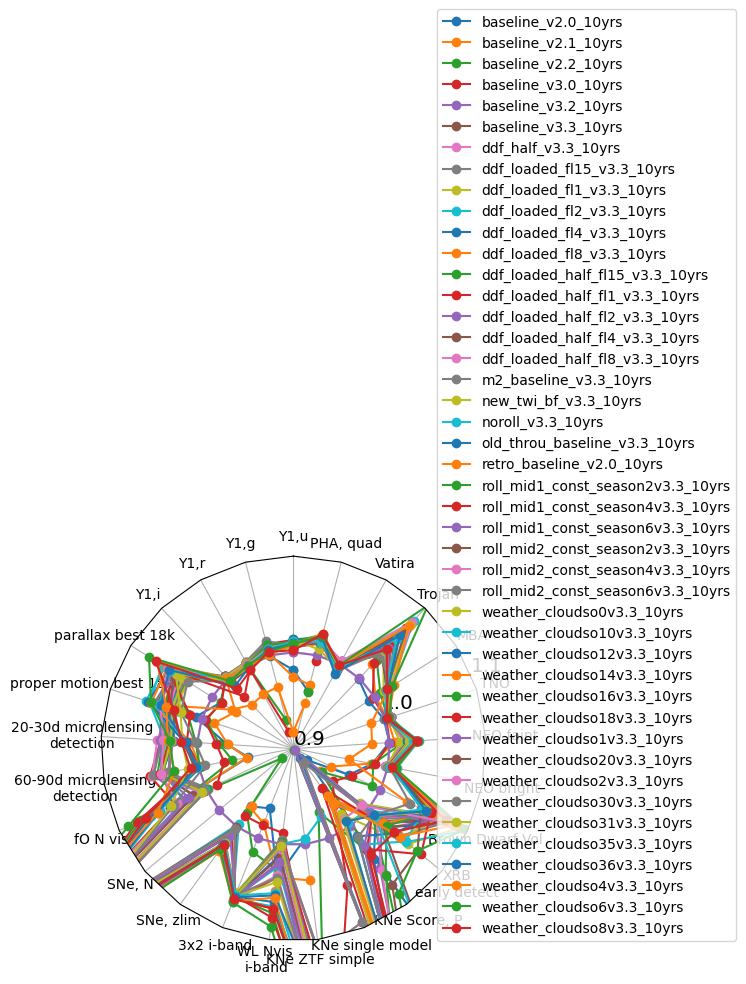

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

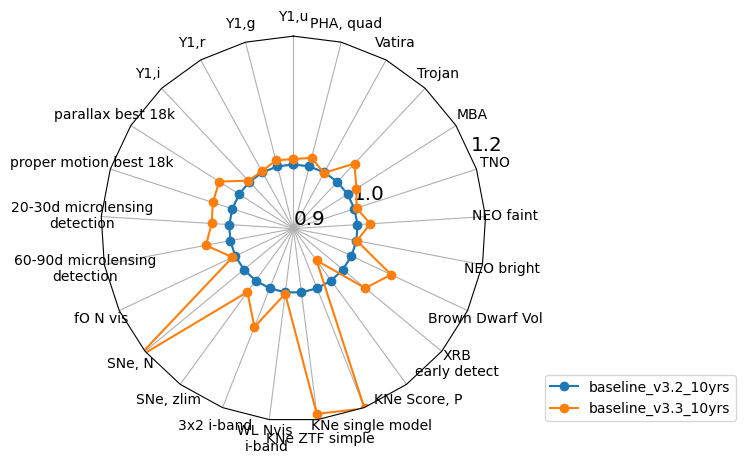

In [12]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

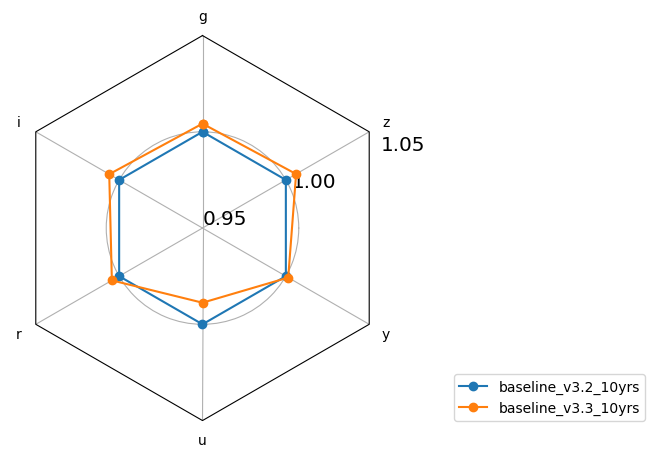

In [13]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

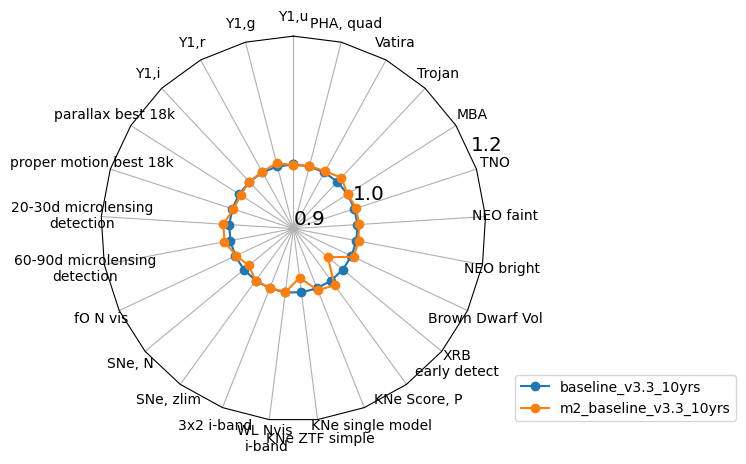

In [14]:
# Look at difference between cluster and Apple chips
runs = ['baseline_v3.3_10yrs', 'm2_baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

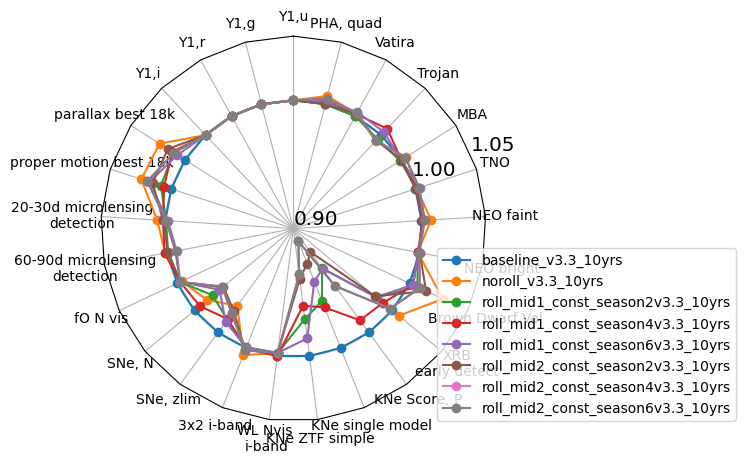

In [15]:
# various rolling
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'roll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [16]:


times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   
baseline_v3.3_10yrs        0.981864  0.992094  0.998023  0.998271   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.868015                0.237797   
baseline_v2.0_10yrs                 0.855901                0.247272   
baseline_v2.1_10yrs                 0.871914                0.252435   
baseline_v2.2_10yrs                 0.855789                0.250178   
baseline_v3.0_10yrs                 0.856875                0.249795   
baseline_v3.2_10yrs                 0.846766                0.248969   
baseline_v3.3_10yrs                 0.816675                0.241255   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0878   
baseline_v2.0_10yrs                                0.3103   
baseline_v2.1_10yrs                                0.3098   
baseline_v2.2_10yrs                                0.3185   
baseline_v3.0_10yrs                                0.3219   
baseline_v3.2_10yrs                                0.3415   
baseline_v3.3_10yrs                                0.3691   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1527     848.0   
baseline_v2.0_10yrs                                0.4270     839.0   
baseline_v2.1_10yrs                                0.4285     838.0   
baseline_v2.2_10yrs                                0.4437     830.0   
baseline_v3.0_10yrs                                0.4525     795.0   
baseline_v3.2_10yrs                                0.4792     805.0   
baseline_v3.3_10yrs                                0.5179     809.0   

                                  SNe, N  ...  KNe Score, P  \
retro_baseline_v2.0_10yrs   97124.012102  ...    202.730488   
baseline_v2.0_10yrs         99302.532220  ...    263.906551   
baseline_v2.1_10yrs         99294.339899  ...    243.713720   
baseline_v2.2_10yrs        112802.099640  ...    242.377184   
baseline_v3.0_10yrs        109475.798536  ...    228.428876   
baseline_v3.2_10yrs        123176.659086  ...    234.851082   
baseline_v3.3_10yrs        149723.614650  ...    225.761367   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              720.0    157615.051927      0.9048   
baseline_v2.0_10yrs                   1882.0    147431.584297      0.9294   
baseline_v2.1_10yrs                   1918.0    144316.131592      0.9286   
baseline_v2.2_10yrs                   1921.0    151528.307785      0.9304   
baseline_v3.0_10yrs                   1952.0    147933.917113      0.9326   
baseline_v3.2_10yrs                   2048.0    152938.872720      0.9460   
baseline_v3.3_10yrs                   2141.0    163399.434167      0.9468   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.624144  0.705922  0.943673  0.667514  0.0000   
baseline_v2.0_10yrs         0.642165  0.719712  0.919119  0.588234  0.0039   
baseline_v2.1_10yrs         0.647818  0.723396  0.927584  0.609144  0.0017   
baseline_v2.2_10yrs         0.657736  0.723964  0.933674  0.615614  0.0008   
baseline_v3.0_10yrs         0.642444  0.722371  0.924274  0.611475  0.0376   
baseline_v3.2_10yrs         0.642240  0.720853  0.926557  0.589189  0.4628   
baseline_v3.3_10yrs         0.662324  0.724403  0.942888  0.628373  0.4619   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847855  
baseline_v2.0_10yr

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_6919/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


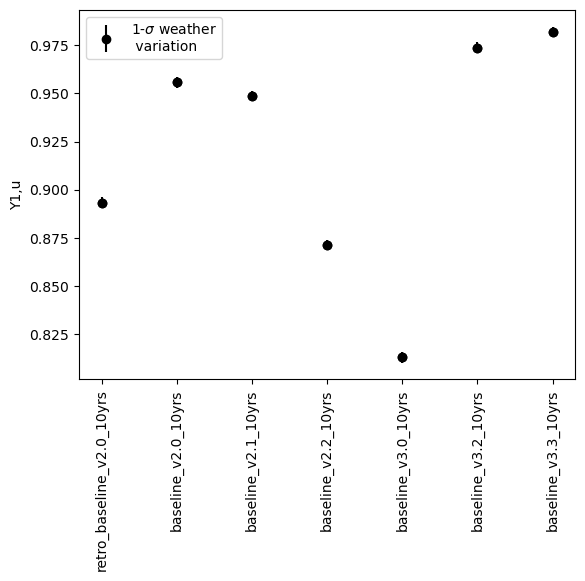

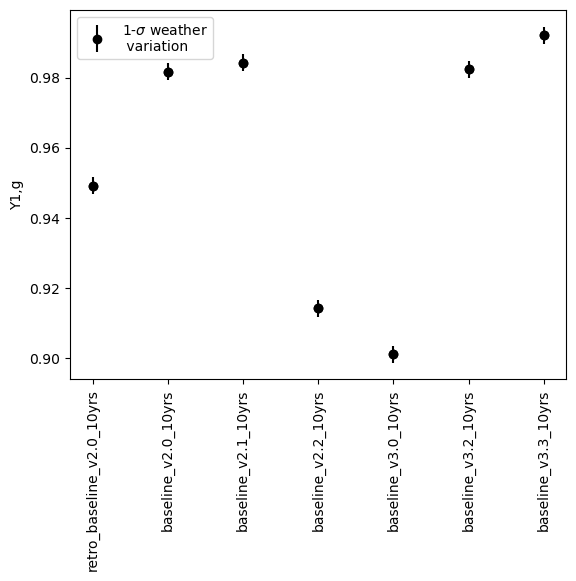

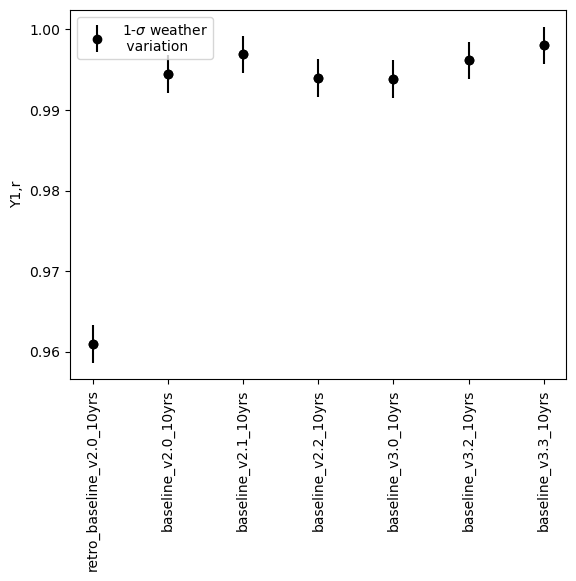

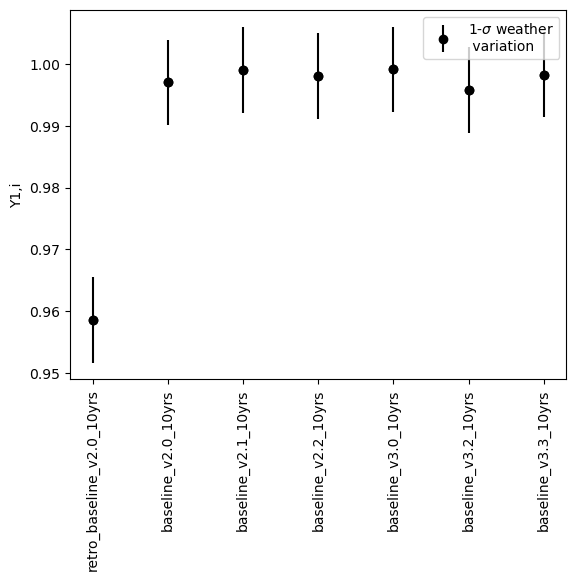

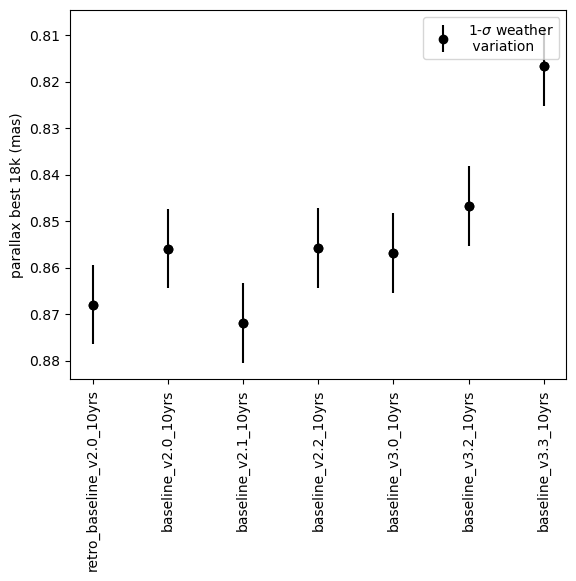

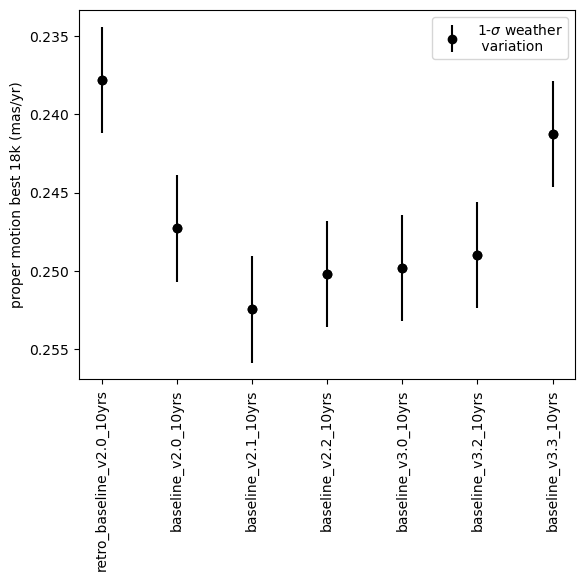

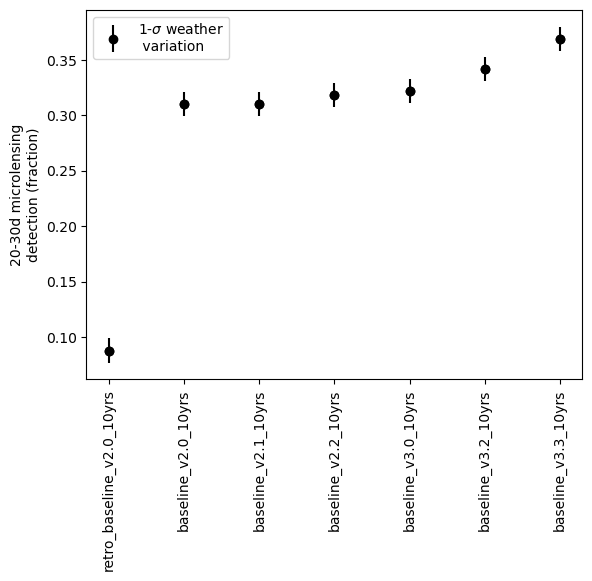

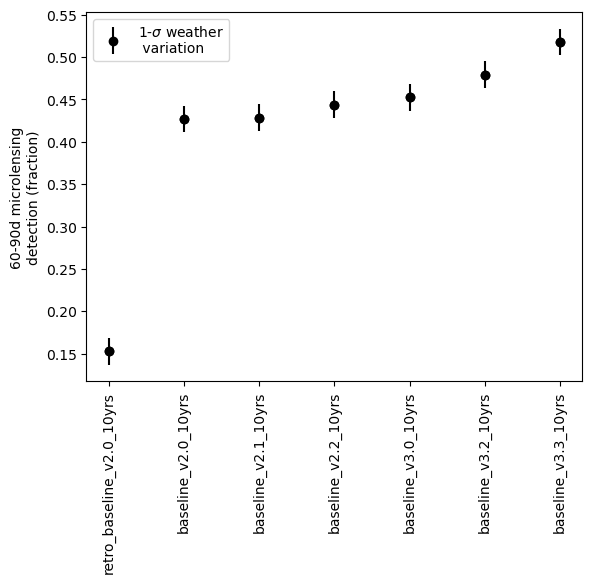

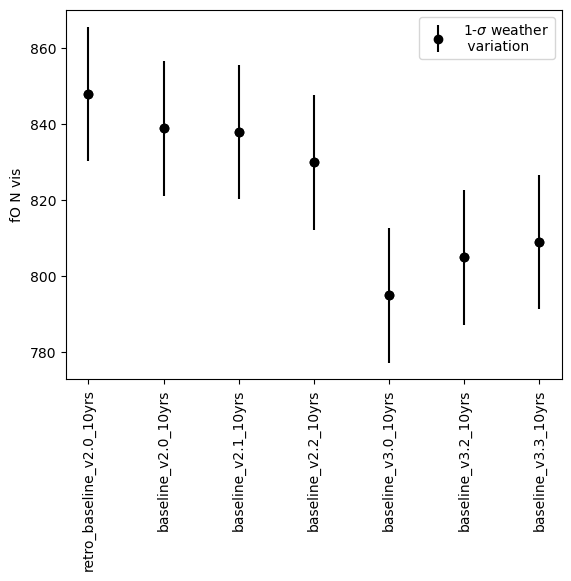

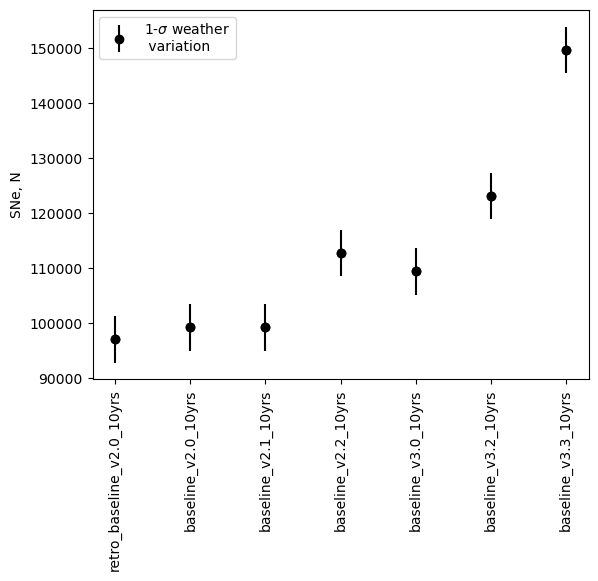

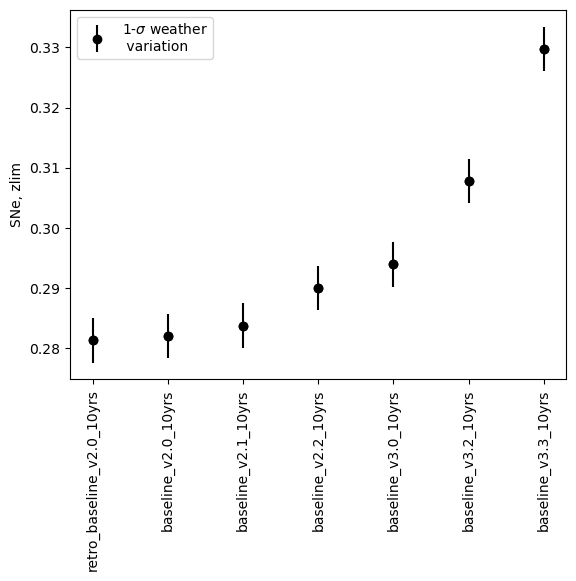

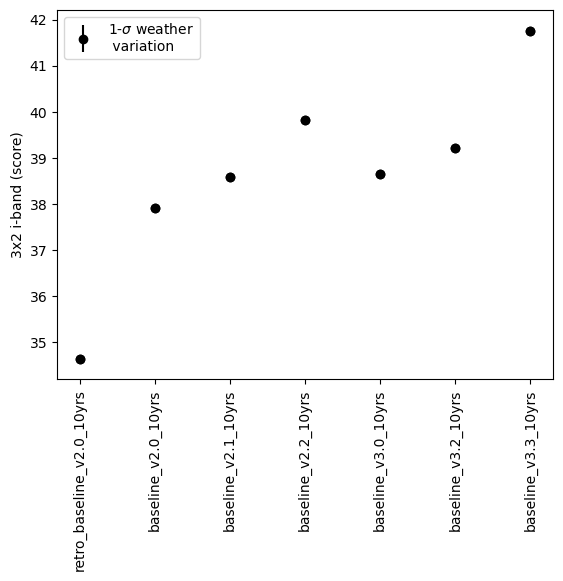

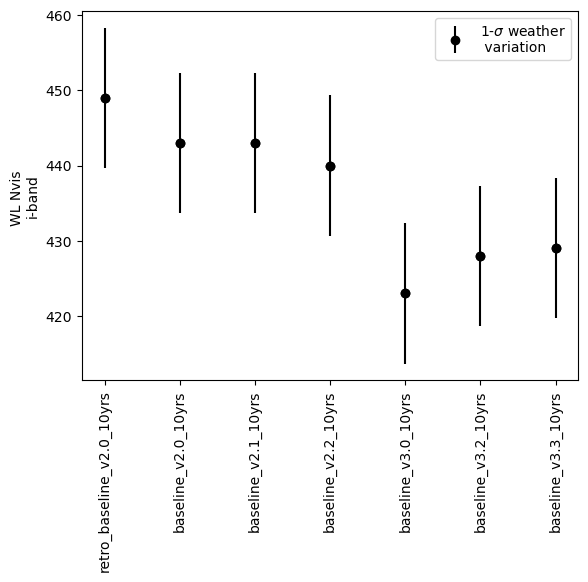

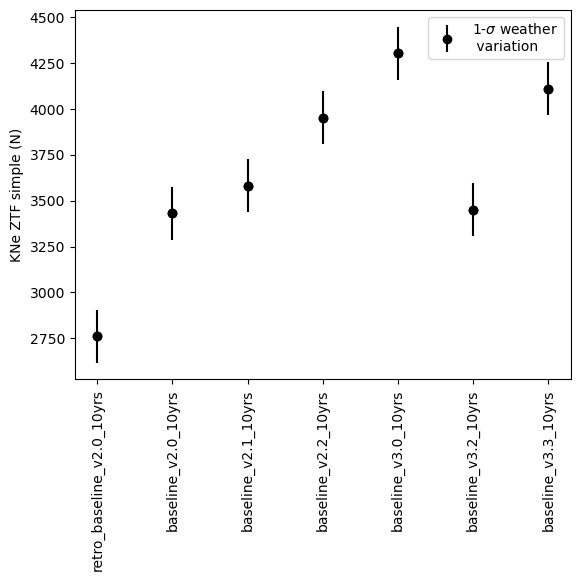

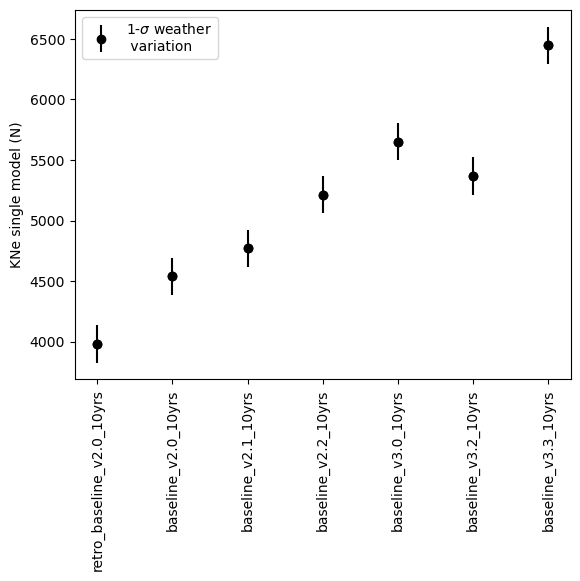

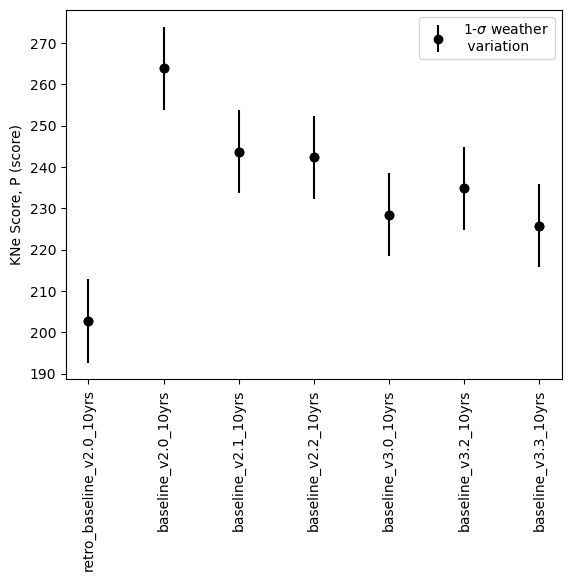

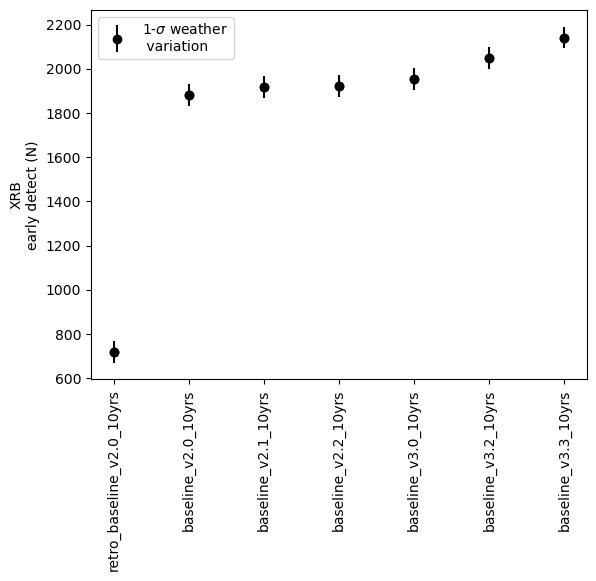

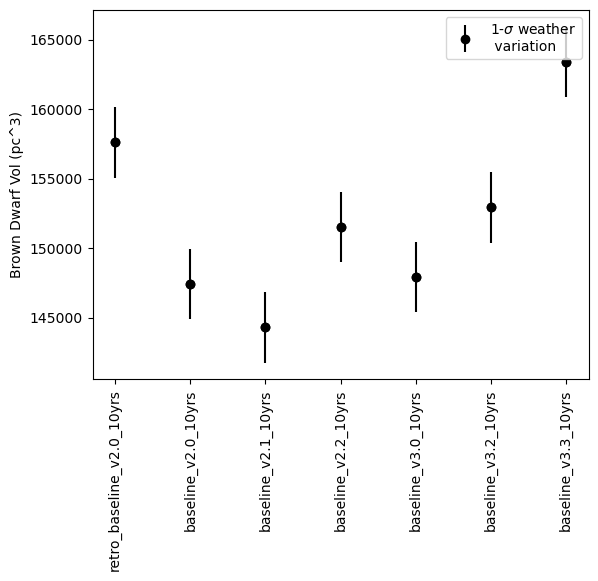

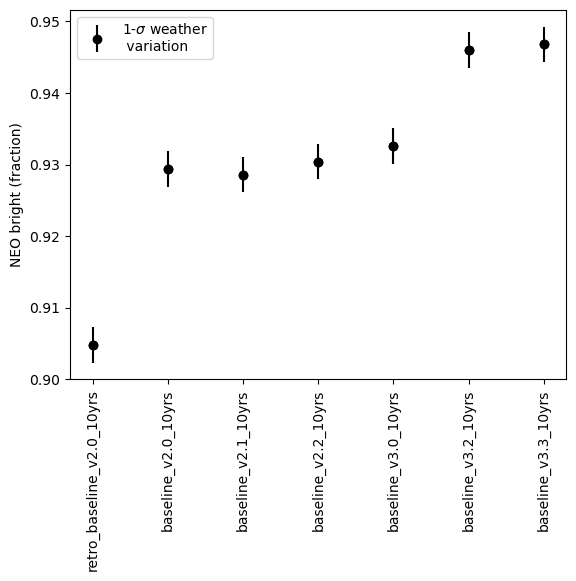

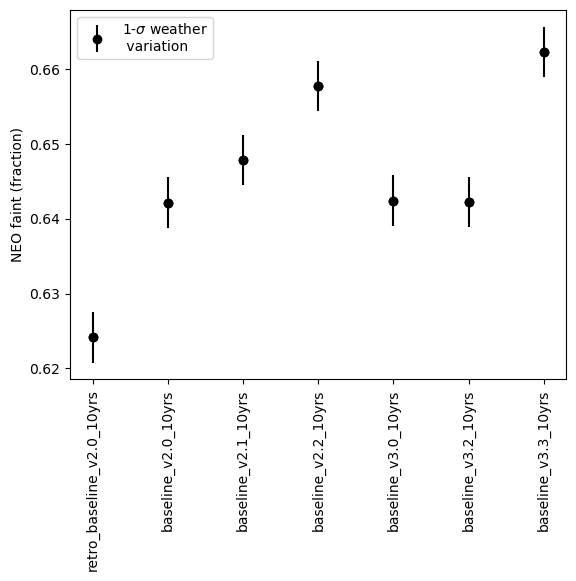

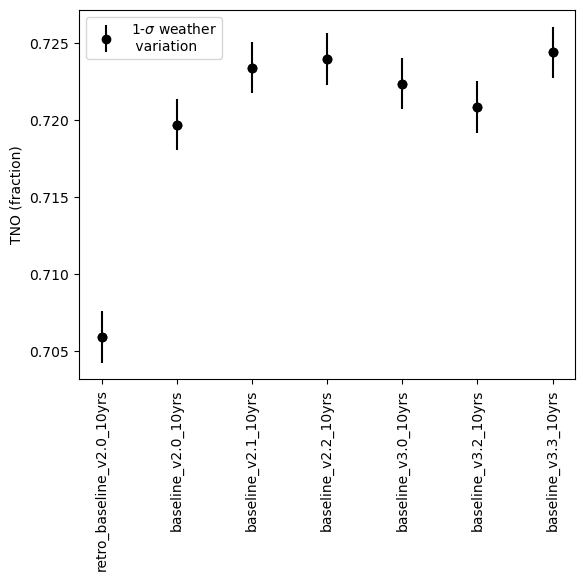

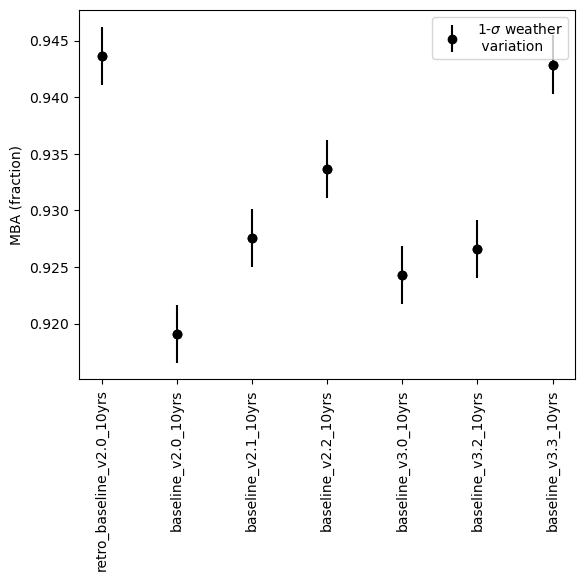

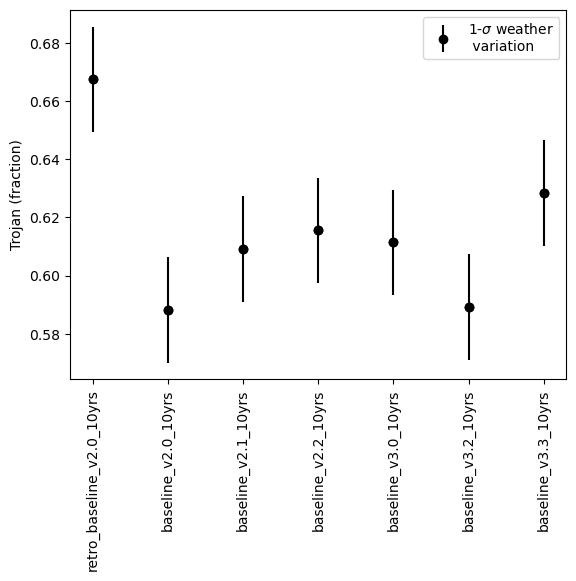

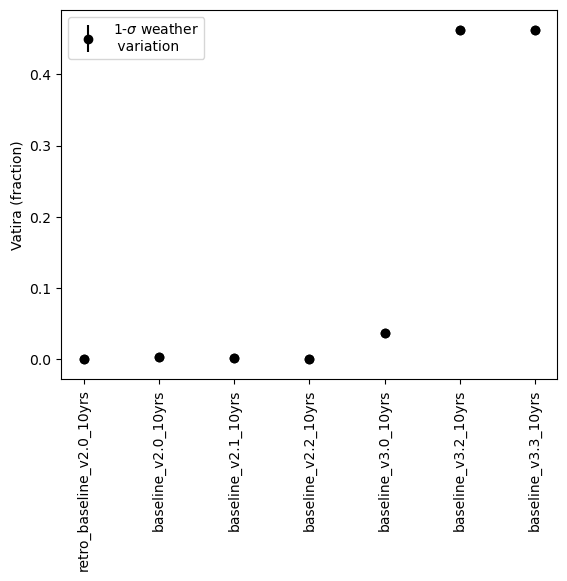

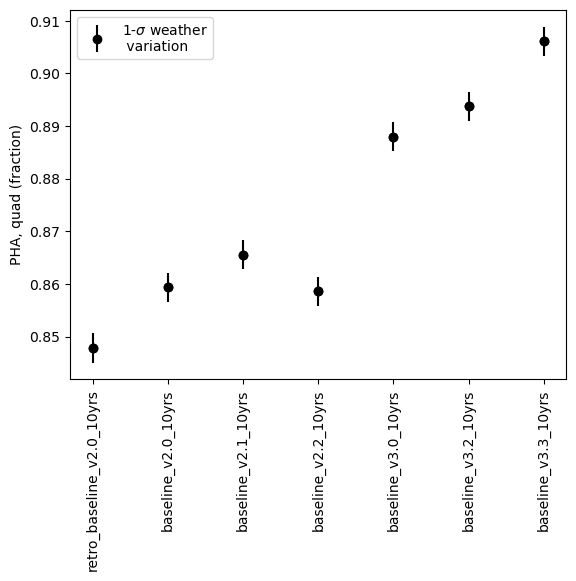

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_6919/1073381334.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',


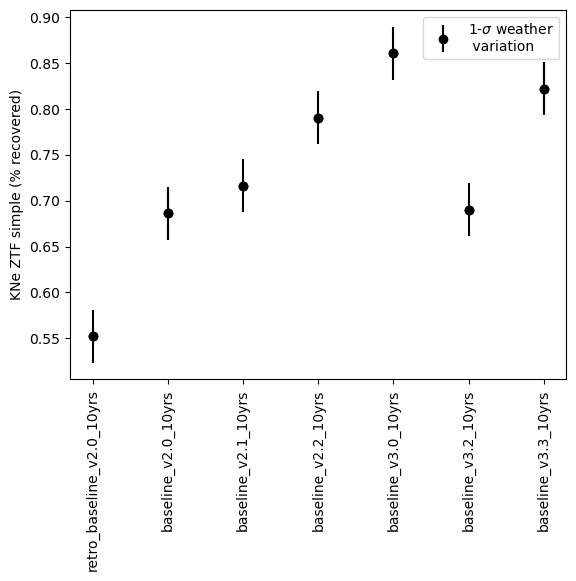

In [18]:
#col = data.columns[0]
n=500000/100
for col in ['KNe ZTF simple']:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col]/n, 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (% recovered)'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_6919/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


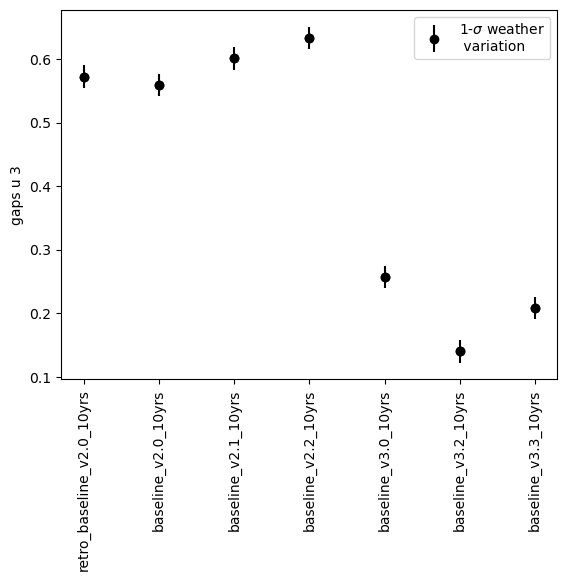

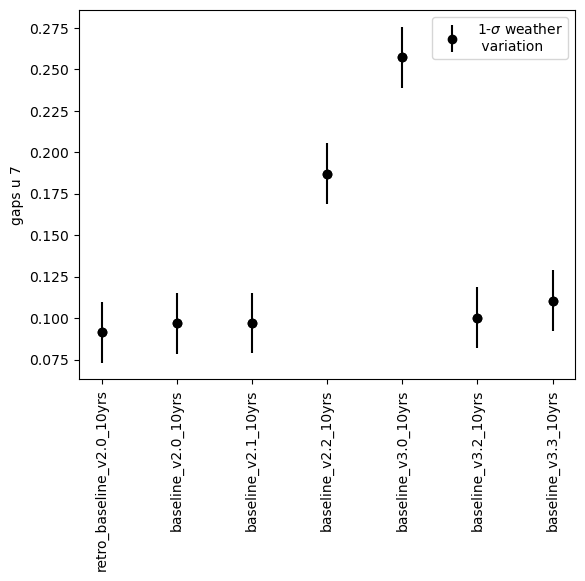

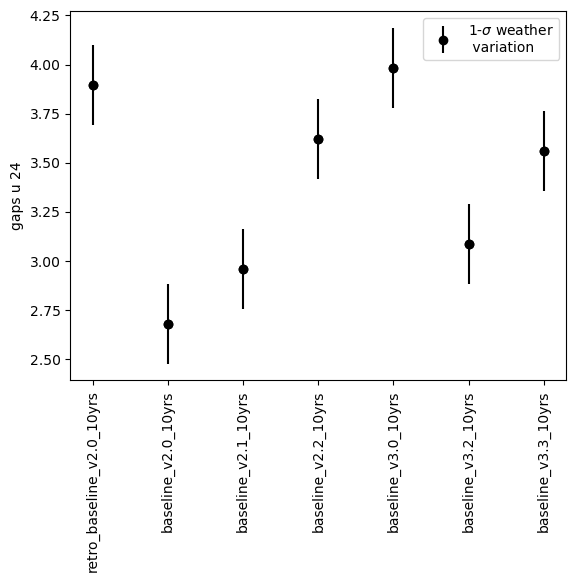

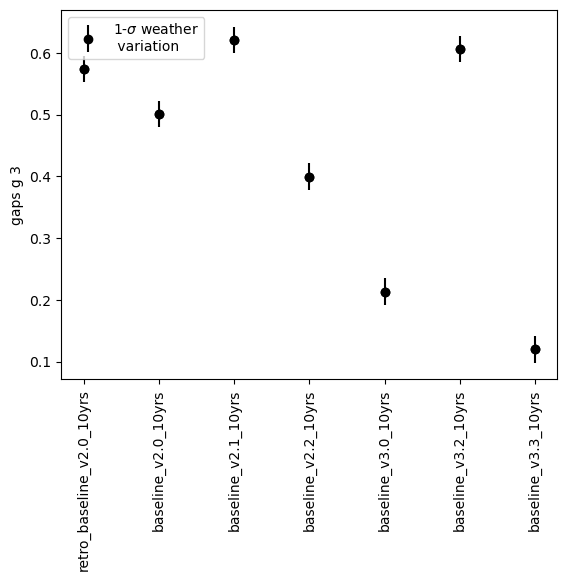

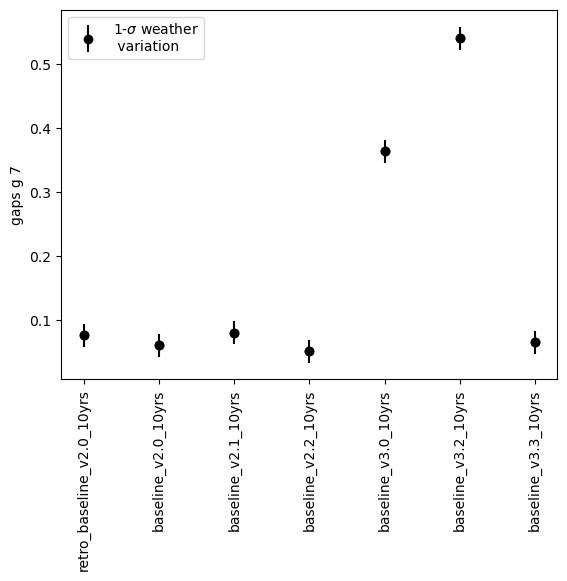

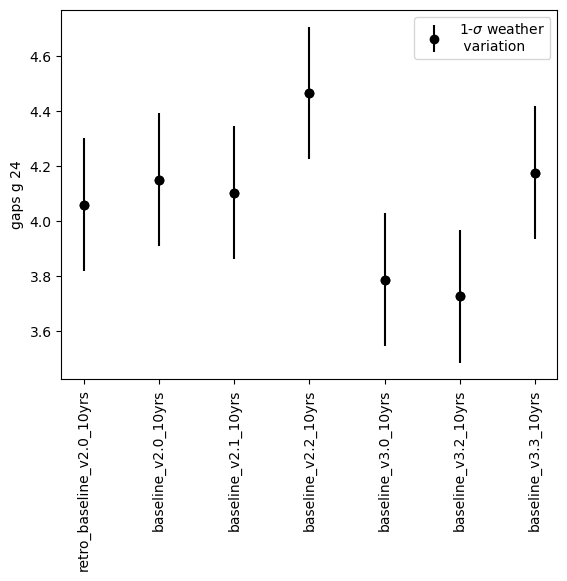

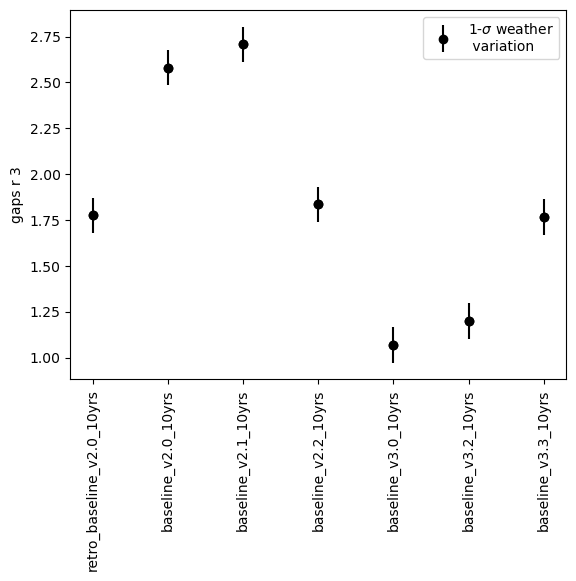

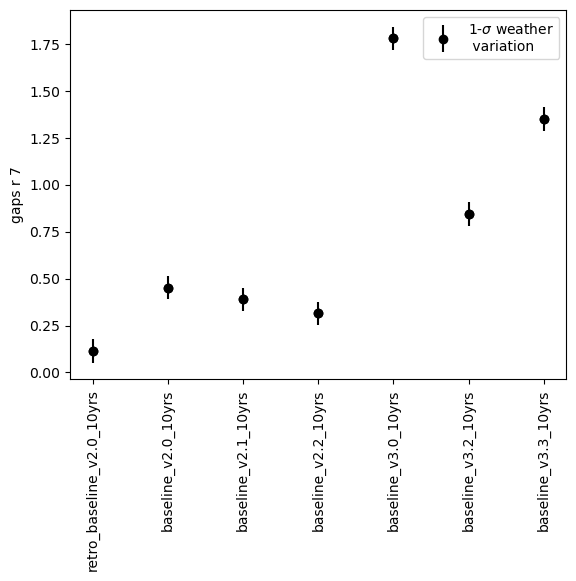

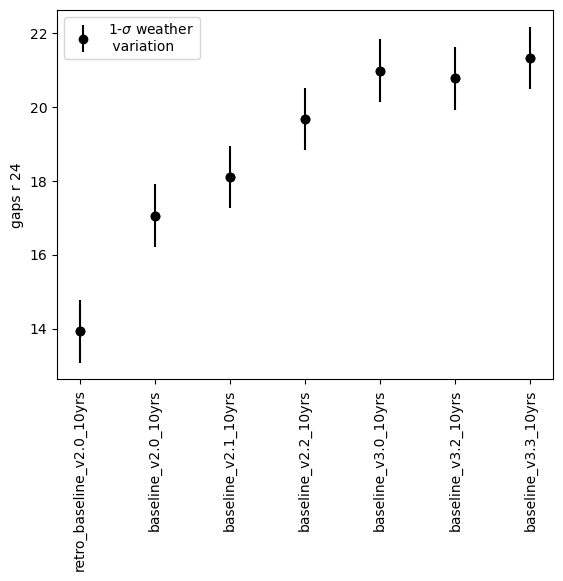

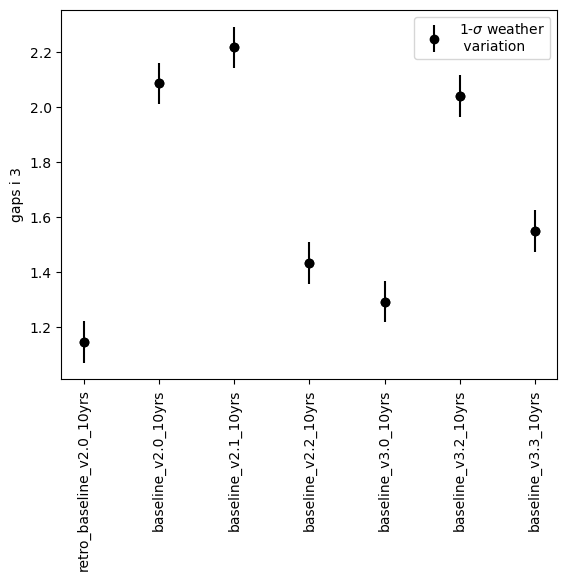

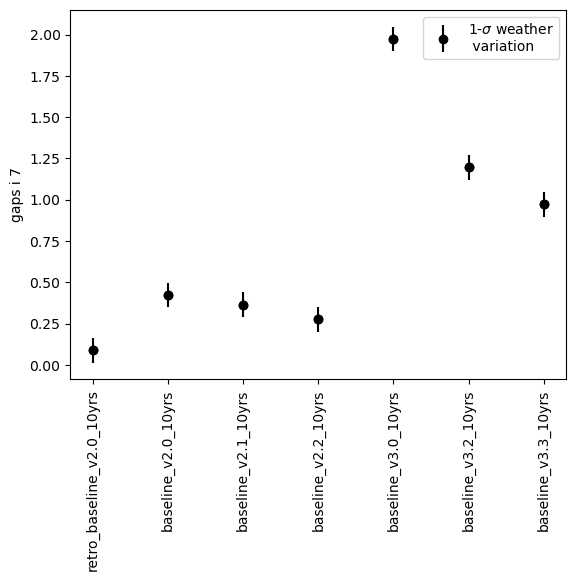

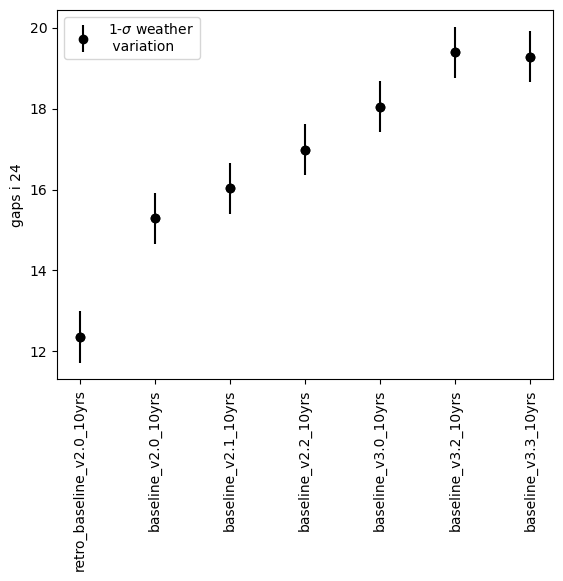

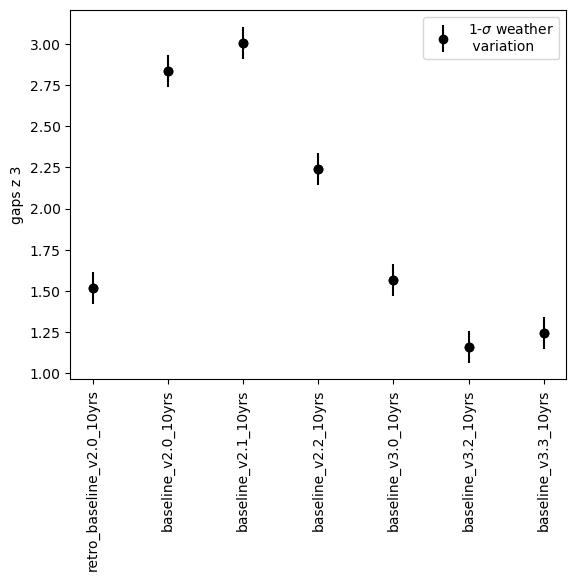

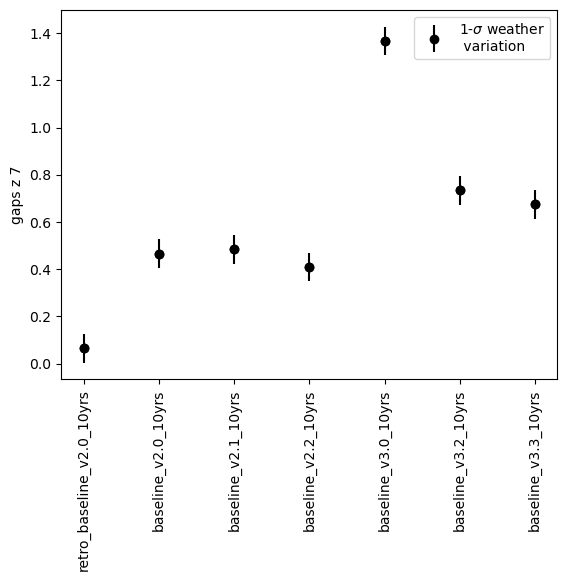

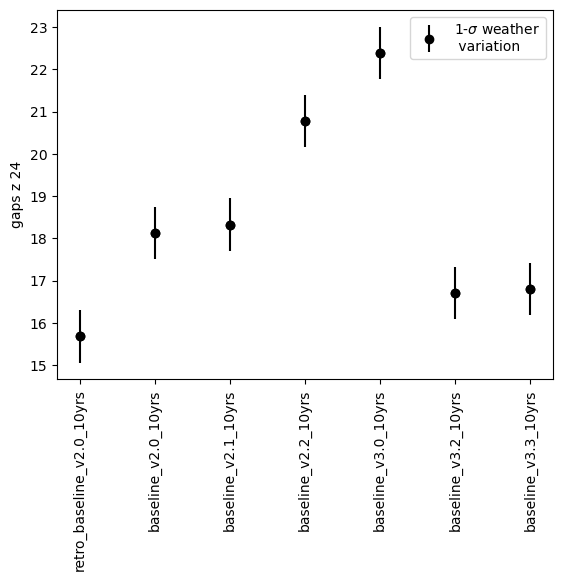

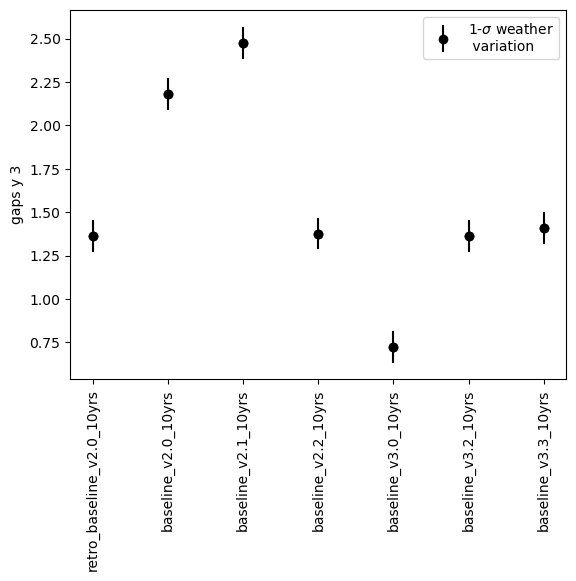

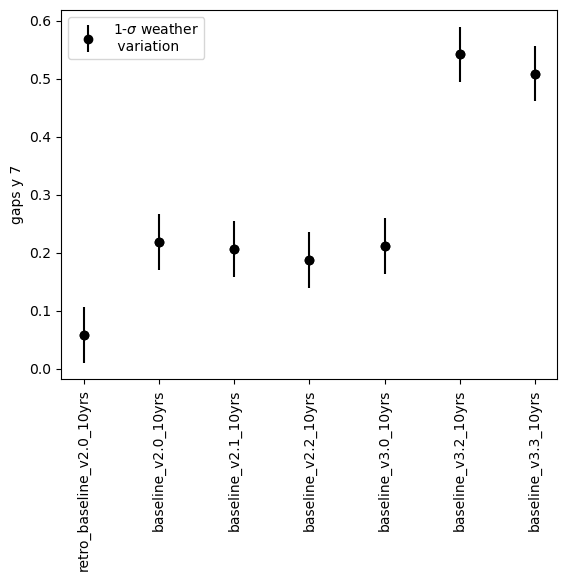

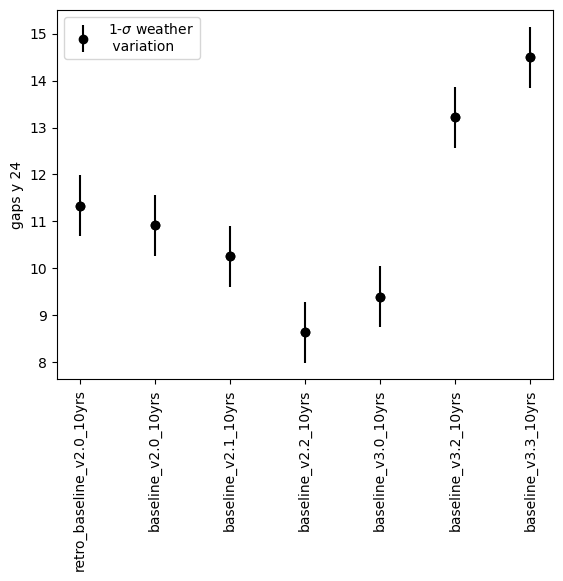

In [19]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_6919/1300353735.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


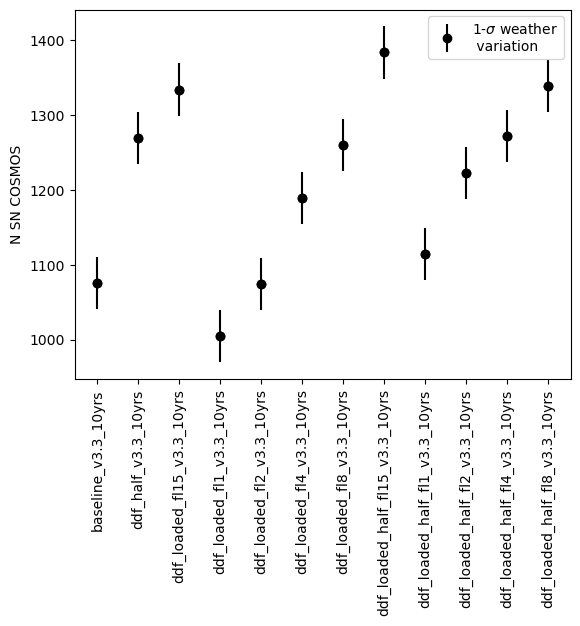

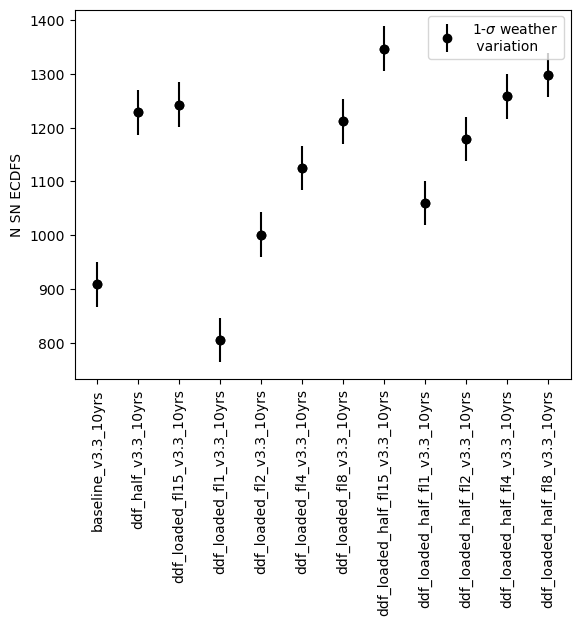

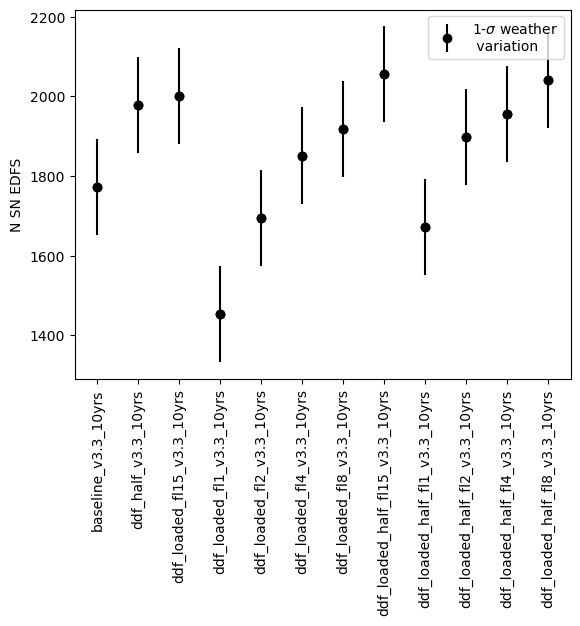

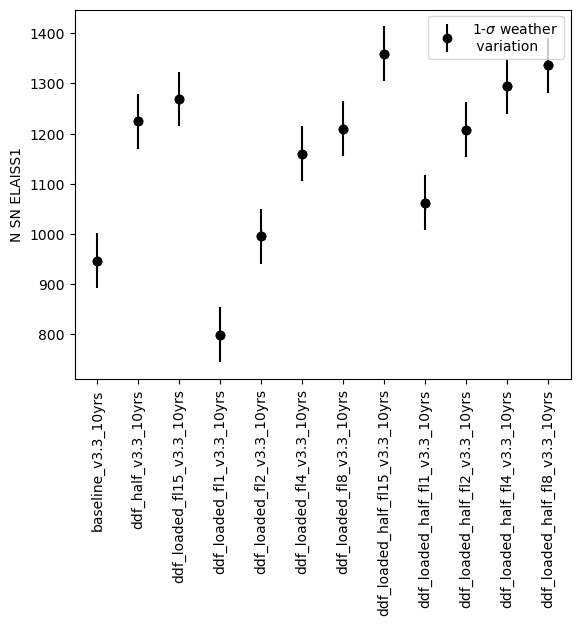

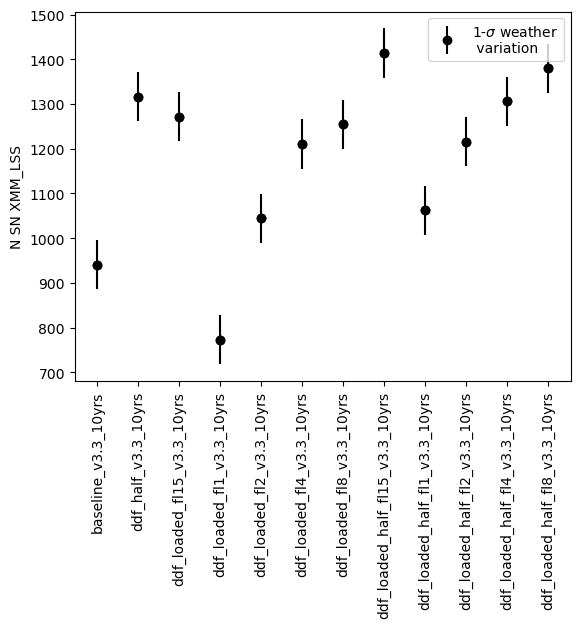

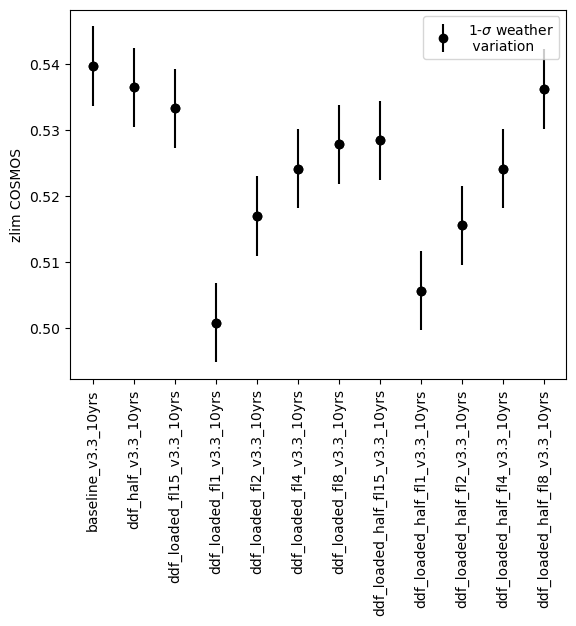

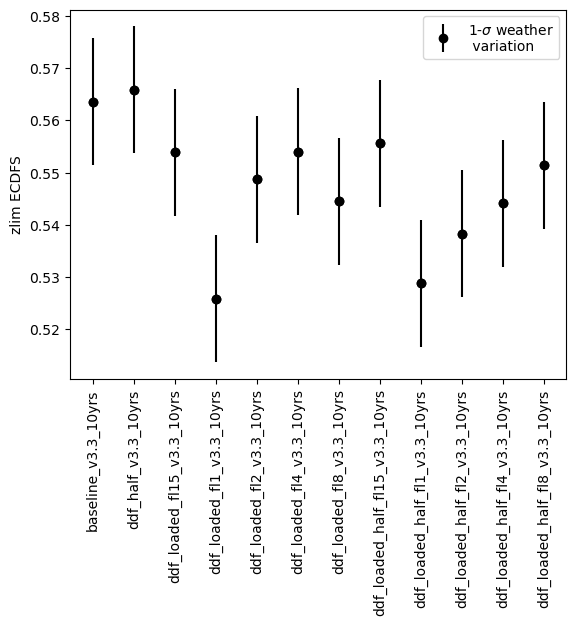

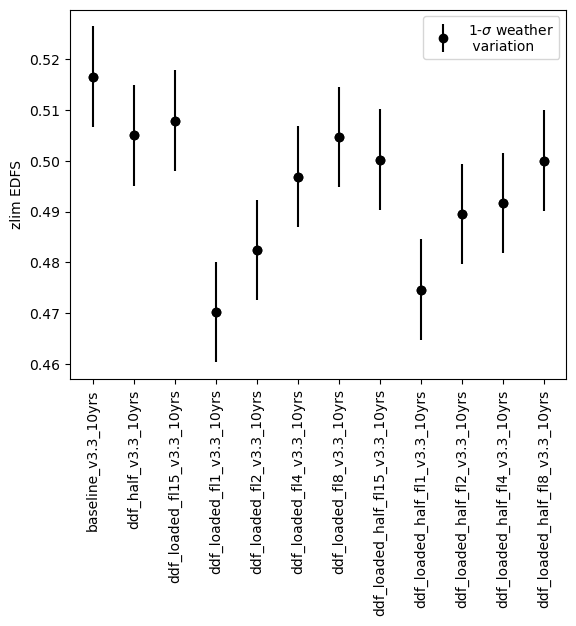

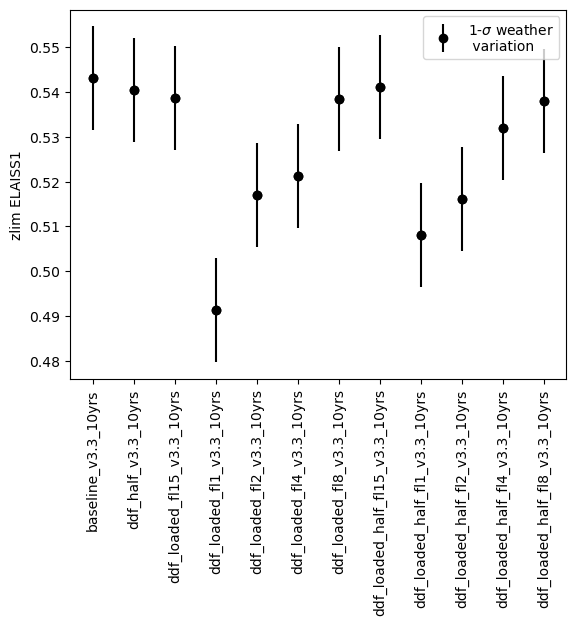

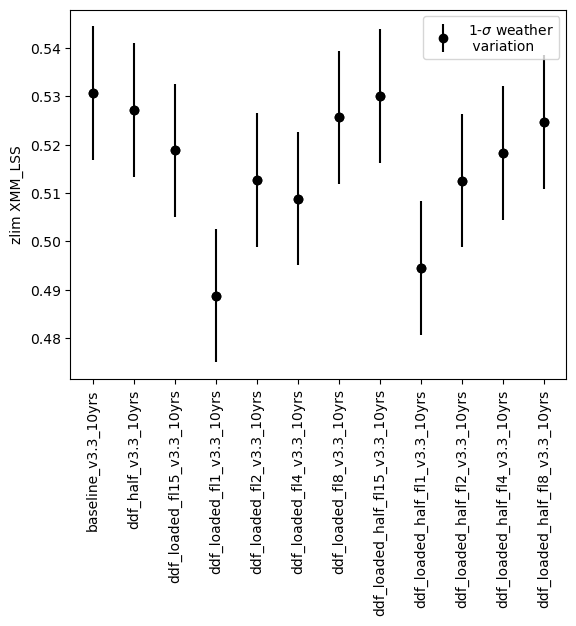

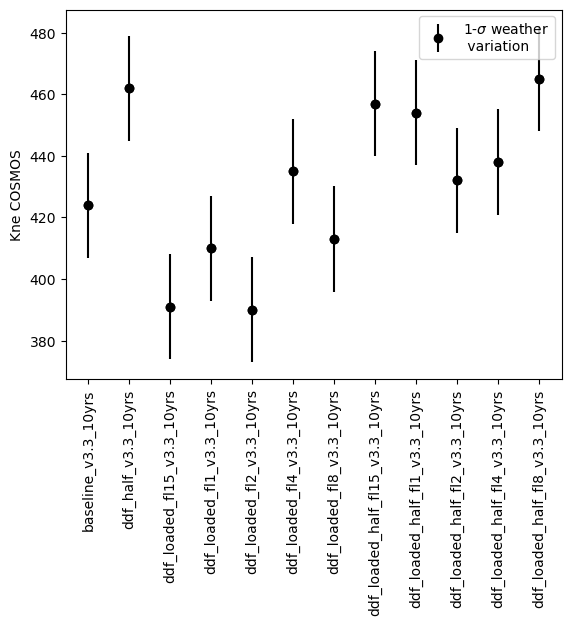

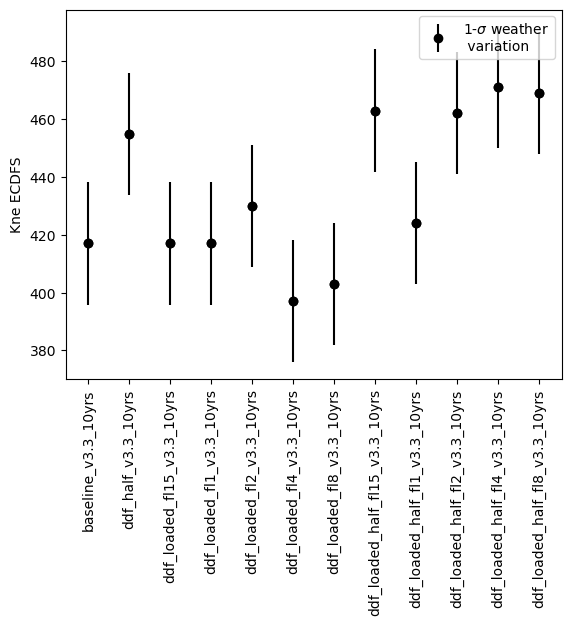

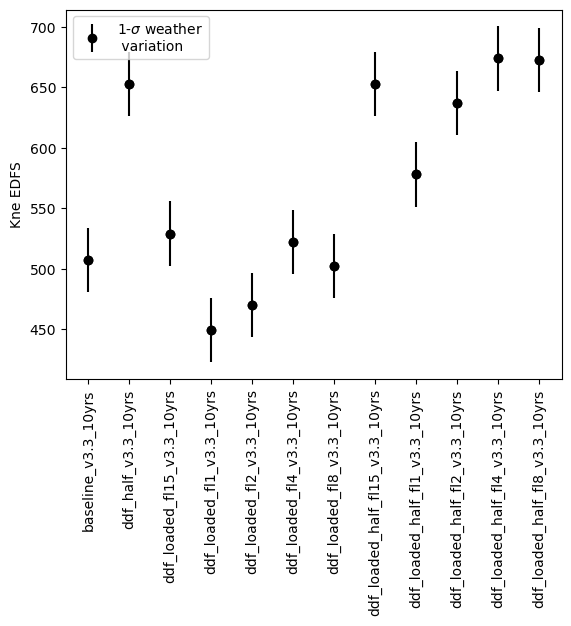

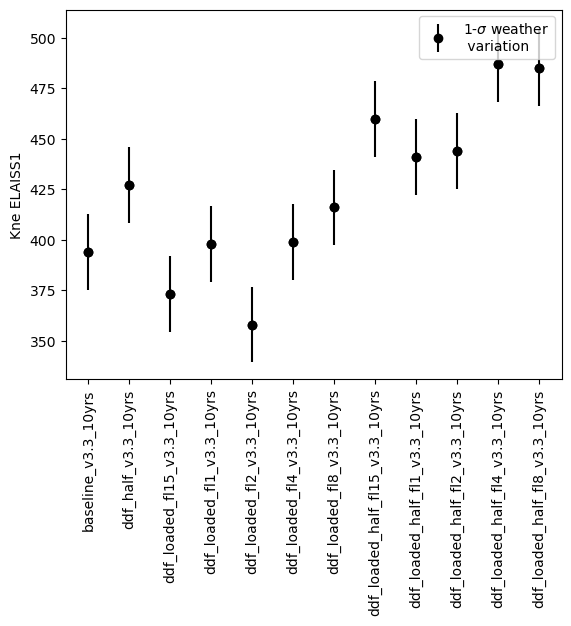

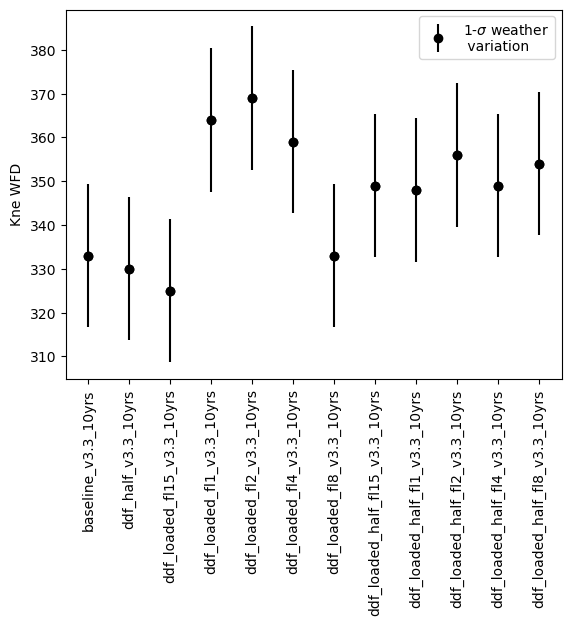

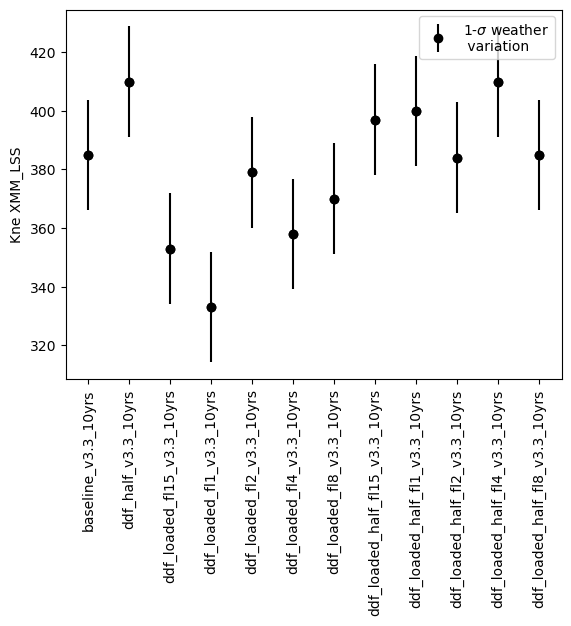

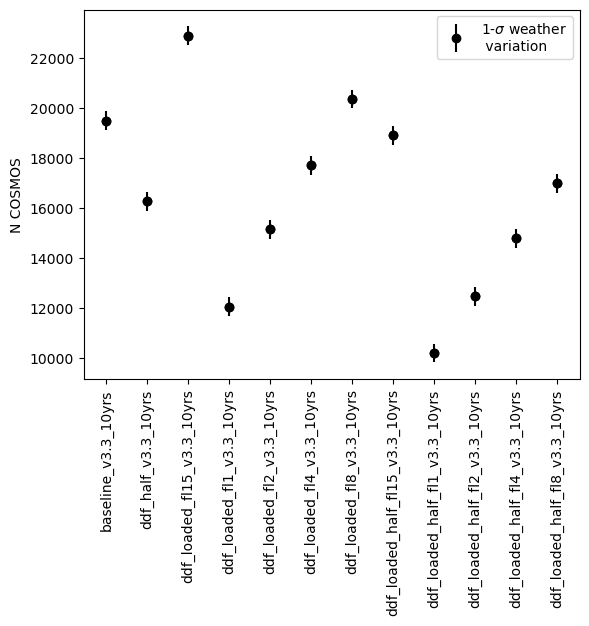

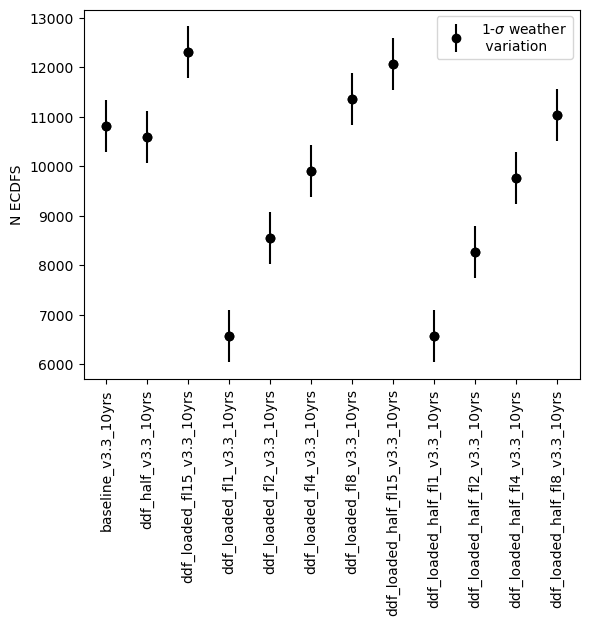

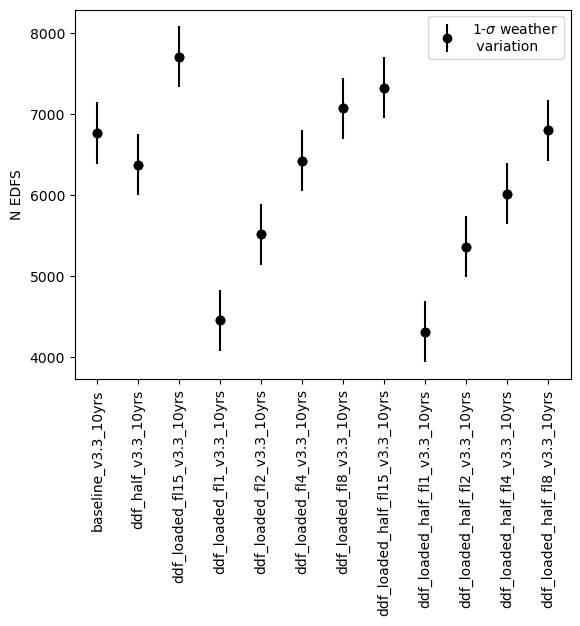

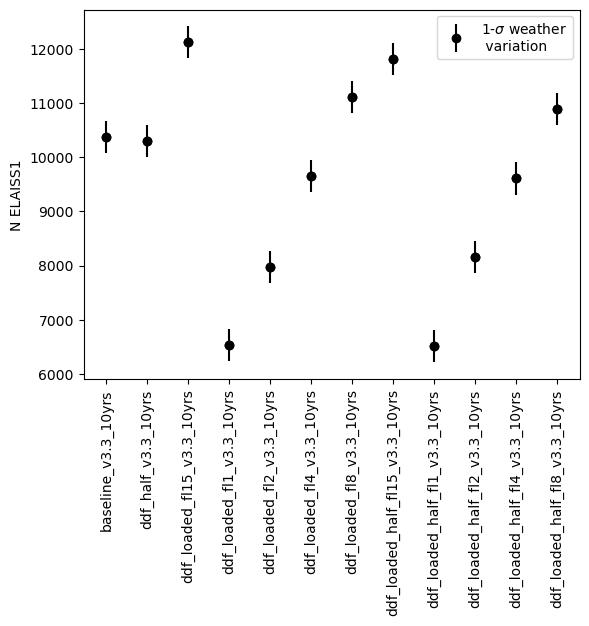

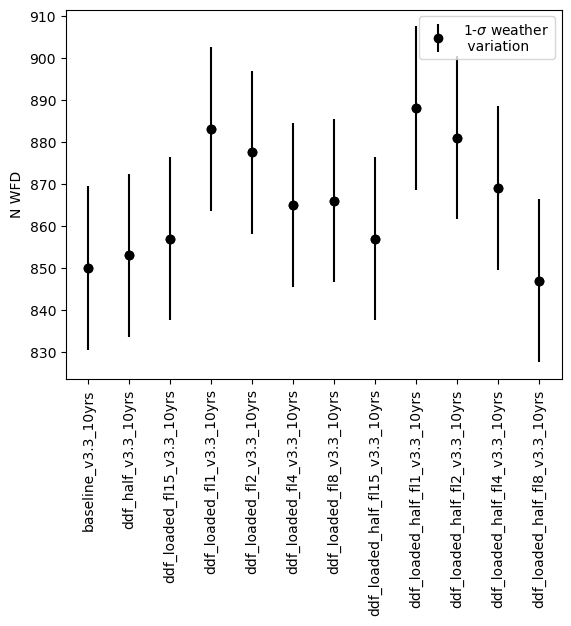

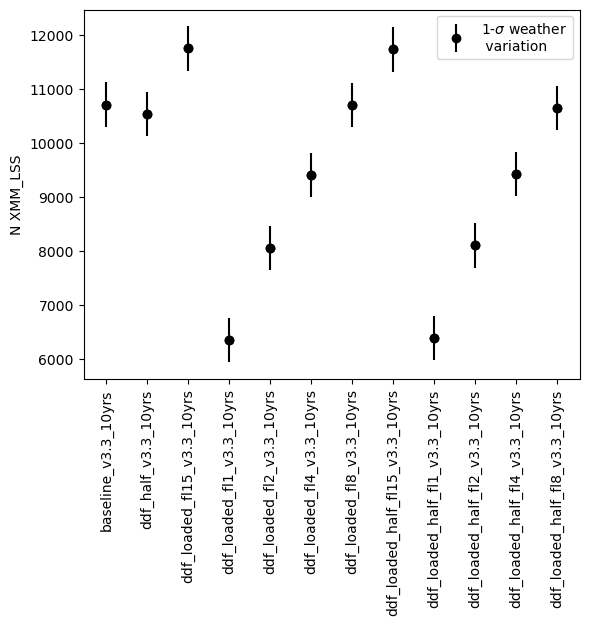

In [20]:
times = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

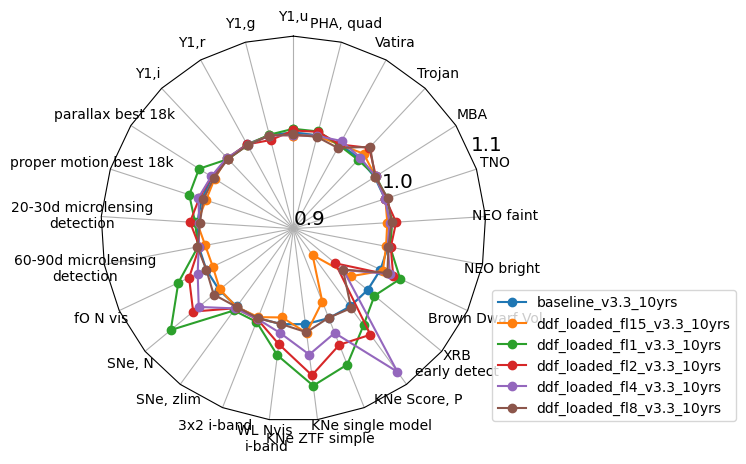

In [21]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

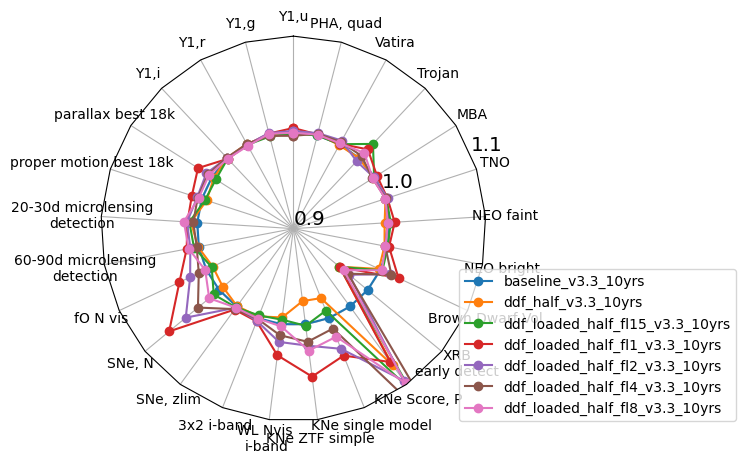

In [22]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

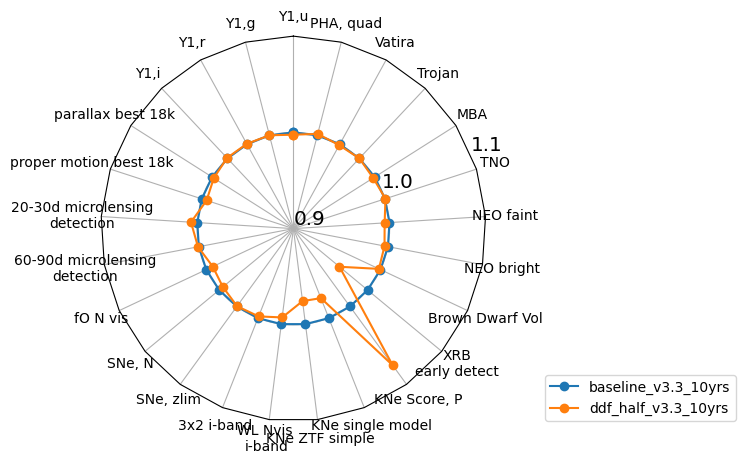

In [23]:
runs = ['baseline_v3.3_10yrs', 'ddf_half_v3.3_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

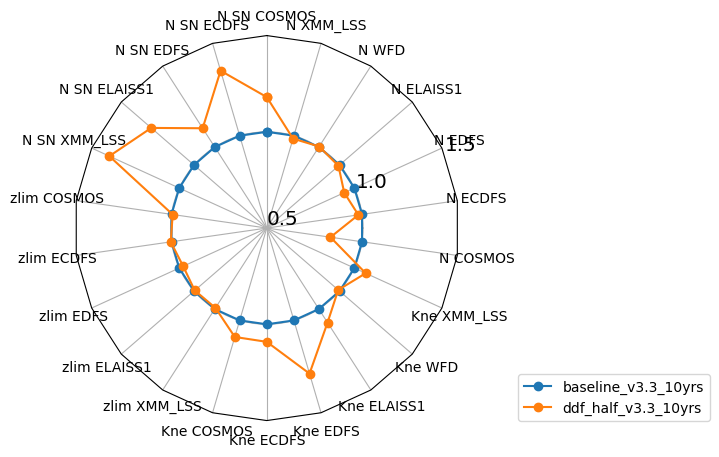

In [24]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

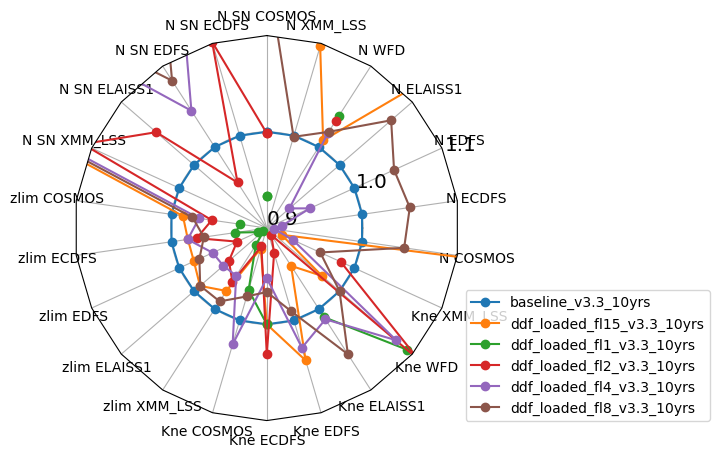

In [25]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [26]:
ndata

N SN COSMOS  N SN ECDFS  N SN EDFS  N SN ELAISS1  \
baseline_v3.3_10yrs            1.000000    1.000000   1.000000      1.000000   
ddf_loaded_fl15_v3.3_10yrs     1.240194    1.367748   1.129527      1.341582   
ddf_loaded_fl1_v3.3_10yrs      0.933643    0.886274   0.819730      0.843661   
ddf_loaded_fl2_v3.3_10yrs      0.998480    1.101729   0.956263      1.052081   
ddf_loaded_fl4_v3.3_10yrs      1.105333    1.237752   1.044873      1.225666   
ddf_loaded_fl8_v3.3_10yrs      1.171799    1.333152   1.082005      1.278577   

                            N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS  \
baseline_v3.3_10yrs             1.000000     1.000000    1.000000   1.000000   
ddf_loaded_fl15_v3.3_10yrs      1.351425     0.988037    0.982809   0.983253   
ddf_loaded_fl1_v3.3_10yrs       0.821306     0.927672    0.932976   0.910213   
ddf_loaded_fl2_v3.3_10yrs       1.110017     0.957723    0.973545   0.933934   
ddf_loaded_fl4_v3.3_10yrs       1.286483     0.971066    0.983027   0.961817   
ddf_loaded_fl8_v3.3_10yrs       1.333254     0.977992    0.966066   0.976974   

                            zlim ELAISS1  zlim XMM_LSS  ...  Kne EDFS  \
baseline_v3.3_10yrs             1.000000      1.000000  ...  1.000000   
ddf_loaded_fl15_v3.3_10yrs      0.991780      0.977673  ...  1.043393   
ddf_loaded_fl1_v3.3_10yrs       0.904628      0.921093  ...  0.885602   
ddf_loaded_fl2_v3.3_10yrs       0.952037      0.966165  ...  0.927022   
ddf_loaded_fl4_v3.3_10yrs       0.959777      0.958824  ...  1.029586   
ddf_loaded_fl8_v3.3_10yrs       0.991567      0.990578  ...  0.990138   

                            Kne ELAISS1   Kne WFD  Kne XMM_LSS  N COSMOS  \
baseline_v3.3_10yrs            1.000000  1.000000     1.000000  1.000000   
ddf_loaded_fl15_v3.3_10yrs     0.946701  0.975976     0.916883  1.173761   
ddf_loaded_fl1_v3.3_10yrs      1.010152  1.093093     0.864935  0.618197   
ddf_loaded_fl2_v3.3_10yrs      0.908629  1.108108     0.984416  0.777256   
ddf_loaded_fl4_v3.3_10yrs      1.012690  1.078078     0.929870  0.908065   
ddf_loaded_fl8_v3.3_10yrs      1.055838  1.000000     0.961039  1.044184   

                             N ECDFS    N EDFS  N ELAISS1     N WFD  N XMM_LSS  
baseline_v3.3_10yrs         1.000000  1.000000   1.000000  1.000000   1.000000  
ddf_loaded_fl15_v3.3_10yrs  1.138185  1.138614   1.168820  1.008235   1.096865  
ddf_loaded_fl1_v3.3_10yrs   0.607976  0.659081   0.629676  1.038824   0.592945  
ddf_loaded_fl2_v3.3_10yrs   0.791173  0.815132   0.768993  1.032353   0.752240  
ddf_loaded_fl4_v3.3_10yrs   0.915526  0.949313   0.931161  1.017647   0.878406  
ddf_loaded_fl8_v3.3_10yrs   1.050102  1.045367   1.070960  1.018824   0.998787  

[6 rows x 22 columns]

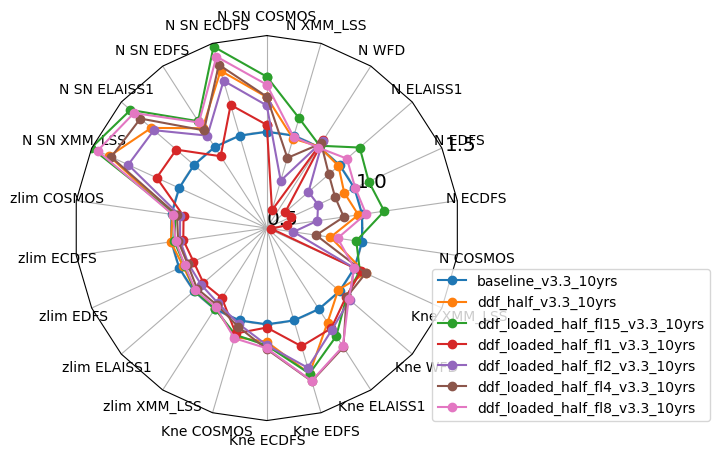

In [27]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [28]:

sub_mag




g          i          r          u  \
retro_baseline_v2.0_10yrs  26.835006  26.308518  26.850968  25.707301   
baseline_v2.0_10yrs        26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs        26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs        26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs        26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs        26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs        26.791240  26.452295  26.924920  25.335268   

                                   y          z  
retro_baseline_v2.0_10yrs  24.842363  25.606168  
baseline_v2.0_10yrs        24.762720  25.510379  
baseline_v2.1_10yrs        24.728145  25.486640  
baseline_v2.2_10yrs        24.782743  25.581317  
baseline_v3.0_10yrs        24.756955  25.524781  
baseline_v3.2_10yrs        24.766647  25.586860  
baseline_v3.3_10yrs        24.801880  25.744020

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_6919/2717096801.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


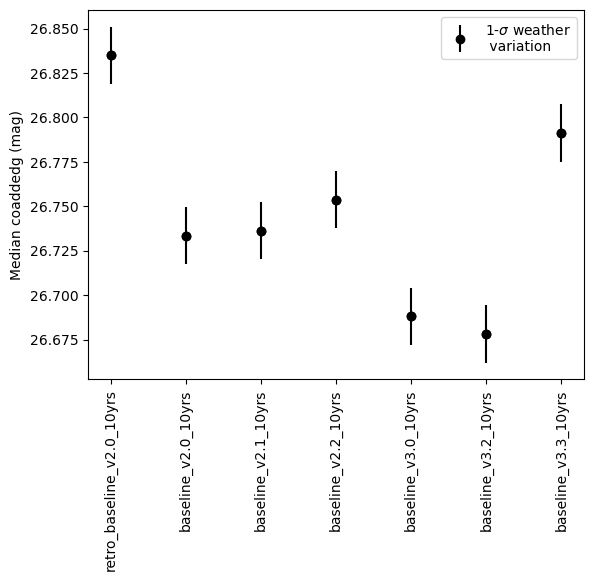

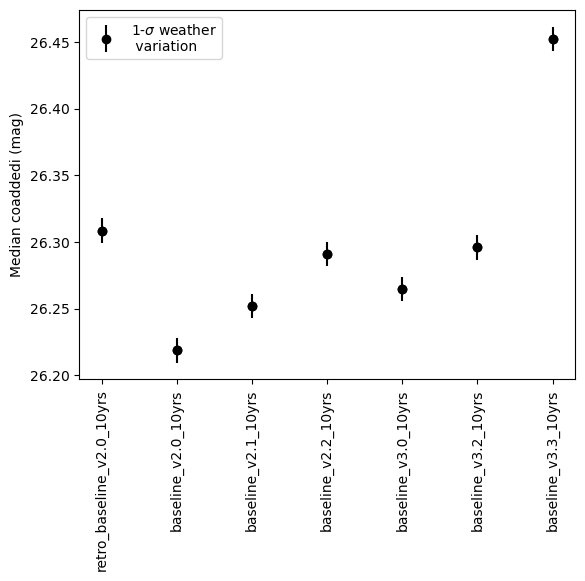

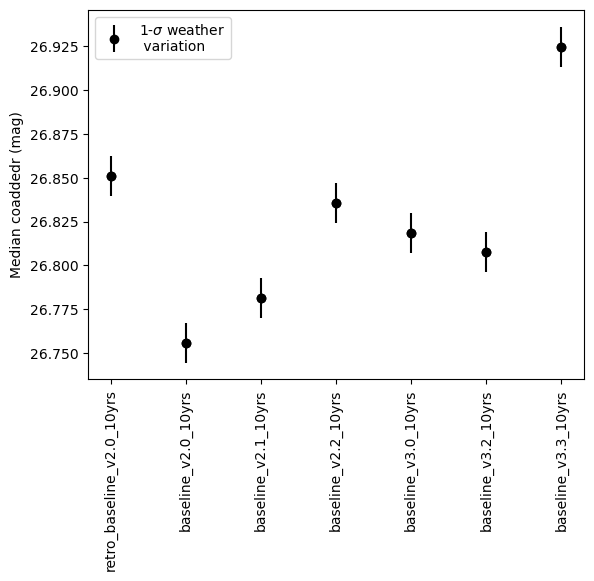

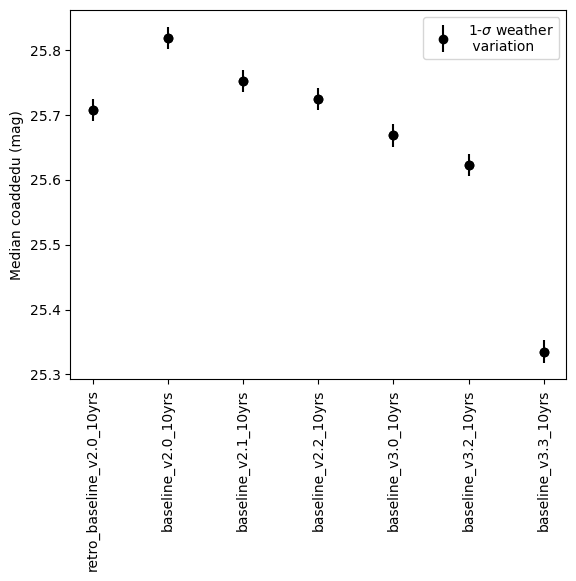

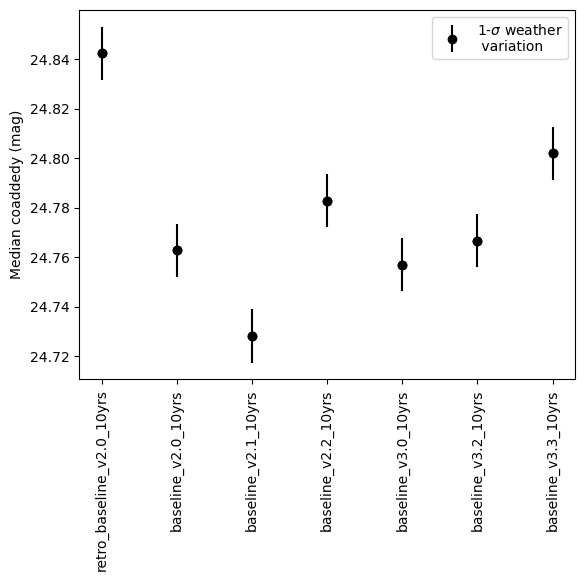

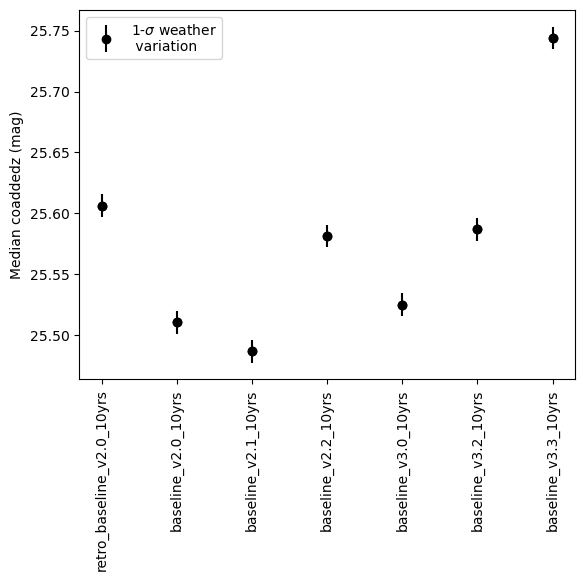

In [29]:
# Rough error bars from weather simulations

#col = data.columns[0]
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    
    label_add = ' (mag)'
    ax.set_ylabel('Median coadded' + col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])
